## PULVAR NOTEBOOK
### FOR PULSAR VARIABILITY ANALYSIS 

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sys
import pulvar_functions as pvf
import os
from matplotlib.patches import Rectangle
from tqdm import tqdm_notebook
from matplotlib import gridspec
import george
from george import kernels
from scipy.optimize import minimize
import scipy.signal as scisig
import datetime

### ENTER PATH FOR THE INPUT TEXT FILE:

In [6]:
matrix_file = 'B1937+21_GBT_820.txt'

rawdata = np.loadtxt(matrix_file)

print('This data set contains',rawdata.shape[1],'pulsar observations, each with',rawdata.shape[0]-1,'phase bins.')

This data set contains 77 pulsar observations, each with 2048 phase bins.


### ENTER NAME OF DIRECTORY IN WHICH THINGS WILL BE SAVED:

In [7]:
directory_name = './B1937+21_820MHZ'

if not (os.path.exists('./{0}/'.format(directory_name))):
    os.mkdir('./{0}/'.format(directory_name))

### (OPTIONAL) RUN THIS CELL IF YOU WOULD LIKE TO PROVIDE A LIST OF DAYS ON WHICH OBSERVATIONS SHOULD BE EXCLUDED FROM THE ANALYSIS:

In [8]:
# LIST OF MJDS TO BE REMOVED:
bad_mjds = [56829]

bad_mjds_index = []
bad_mjds = np.atleast_1d(bad_mjds)
for b in bad_mjds:
    for i in range(rawdata.shape[1]):
        if abs(rawdata[rawdata.shape[0]-1,i]-b) < 1.0:
            bad_mjds_index.append(i)

raw_before = rawdata.shape[1]
rawdata = np.delete(rawdata,bad_mjds_index,1)
raw_after = rawdata.shape[1]

print(raw_before-raw_after,'observations were manually removed')

2 observations were manually removed


### SPLIT THE DATA INTO PROFILES AND MJDS:

In [9]:
mjd = rawdata[rawdata.shape[0]-1,:]
Tobs = rawdata[rawdata.shape[0]-2,:]
data = rawdata[0:rawdata.shape[0]-2,:]
bins = data.shape[0]

### (OPTIONAL) RUN CELL TO SAVE PLOTS OF RAW PROFILES:

In [10]:
pvf.save_profiles(directory_name,data,mjd,data.shape[0],'raw_profile_plots',no_y_lim=True)

  0%|          | 0/75 [00:00<?, ?it/s]

### REMOVE PROFILES WITH NOISE ABOVE A CERTAIN THRESHOLD:

In [11]:
noise_threshold = 2
# (An observation is removed if the standard deviation of the off-pulse region is more than a factor of <noise_threshold> larger than the median value taken from the off-pulse regions across all observations)

baselineremoved, removedprofiles, rmsperepoch, outlierlist, inlierlist = pvf.removebaseline(data, noise_threshold)
mjd_remain = np.delete(mjd,outlierlist)
mjdremoved = np.delete(mjd,inlierlist)

Number of noisy profiles removed:  4


### (OPTIONAL) SAVE PLOTS OF PROFILES THAT WERE REMOVED FOR BEING TOO NOISY:

In [12]:
try:
    pvf.save_profiles(directory_name,removedprofiles,mjdremoved,data.shape[0],'noisy_profile_plots')
except:
    print('Noisy profile removal was not performed. No plots to save.')

  0%|          | 0/4 [00:00<?, ?it/s]

### VIEW THE BRIGHTEST PROFILE IN THE DATA SET:

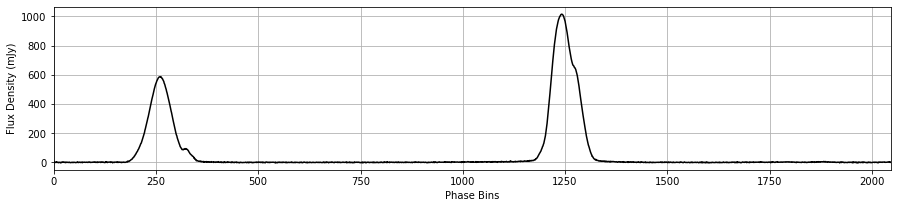

In [13]:
brightest_profile = pvf.findbrightestprofile(baselineremoved,rmsperepoch)
pvf.plot_profile(data[:,brightest_profile]);

### IF S/N IS TOO LOW, RESAMPLE THE DATA TO INCREASE IT:

In [14]:
# SET THE THRESHOLD:
s_n_threshold = 2

brightprofpeak = np.max(baselineremoved[:,brightest_profile])
brightprofrms = rmsperepoch[brightest_profile]

if brightprofpeak/brightprofrms < s_n_threshold :
    print('Resampling...')
    resampled = scisig.resample(baselineremoved,int(bins/8))
else:
    print('Resampling not necessary.')
    resampled = baselineremoved
baselineremoved = resampled

Resampling not necessary.


### CROSS CORRELATE THE PROFILES TO ALIGN THEM AND ALSO NORMALISE PEAKS TO 1.0:

In [15]:
aligned_data, template = pvf.aligndata(baselineremoved, brightest_profile, directory_name)
originaltemplate = np.copy(template)
originaltemplate_normalised = originaltemplate/(np.max(originaltemplate))

### PLOT CURRENT MEDIAN PROFILE (PEAK POSITIONED AT PERIOD / 4):

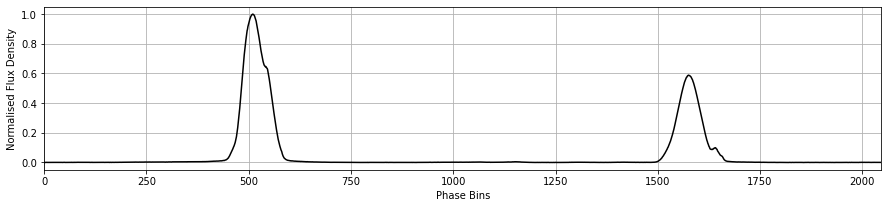

In [16]:
ax = pvf.plot_profile(originaltemplate_normalised)
ax.set_ylabel('Normalised Flux Density');

### CHOOSE THE 'BEGIN' AND 'END' BINS FOR YOUR PULSE WINDOW BASED ON THE ABOVE PROFILE:

In [17]:
window_begin = 440
window_end = 600

### CHOOSE THE WINDOWS FOR ANY OTHER PULSE REGIONS ([BEGIN_1,END_1,BEGIN_2,END_2,...]):

In [18]:
# SO THAT IT IS NOT COUNTED AS AN OFF-PULSE REGION

other_pulse_regions = [1490,1680]

### PLOT TO SEE IF CHOSEN WINDOWS ARE SATISFACTORY (IF NOT EDIT CELLS ABOVE):

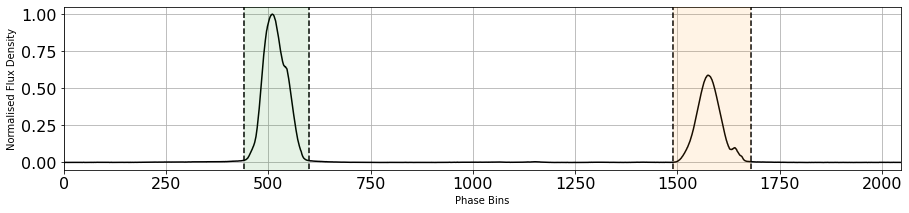

In [30]:
ax = pvf.plot_profile(originaltemplate_normalised)
plt.vlines(window_begin,-0.1,1.1,linestyles='dashed',color='k')
plt.vlines(window_end,-0.1,1.1,linestyles='dashed',color='k')
ax.add_patch(Rectangle((window_begin,-0.1),(window_end-window_begin),1.2,facecolor='green',alpha = 0.1, zorder = 39))
for r in range(int(len(other_pulse_regions)/2)):
    plt.vlines(other_pulse_regions[2*r],-0.1,1.1,linestyles='dashed',color='k')
    plt.vlines(other_pulse_regions[2*r+1],-0.1,1.1,linestyles='dashed',color='k')
    ax.add_patch(Rectangle((other_pulse_regions[2*r],-0.1),(other_pulse_regions[2*r+1]-other_pulse_regions[2*r]),1.2,facecolor='darkorange',alpha = 0.1, zorder = 39))

ax.set_ylabel('Normalised Flux Density');

### RE-ALIGN AND RE-NORMALISE PROFILES BY MAXIMISING NUMBER OF STABLE BINS:

In [20]:
# TAKES A FEW SECONDS PER OBSERVATION

aligned_data_norm, aligned_data = pvf.smart_align(originaltemplate_normalised,baselineremoved[:,:])

  0%|          | 0/71 [00:00<?, ?it/s]

### CALCULATE THE STD ACROSS ALL PROFILES IN THE OFF-PULSE (NON-COLOURED) REGIONS IN PLOT ABOVE:

In [21]:
on_pulse_bins = []

for a in range(window_end-window_begin+1):
    on_pulse_bins.append(window_begin+a)
for b in range(int(len(other_pulse_regions)/2)):
    for c in range(other_pulse_regions[2*b+1]-other_pulse_regions[2*b]+1):
        on_pulse_bins.append(other_pulse_regions[2*b]+c)

off_pulse_data = np.delete(aligned_data_norm,on_pulse_bins,0)

rms = np.std(off_pulse_data)

### VIEW ALL ALIGNED AND NORMALISED PROFILES IN PULSE WINDOW (WITH RED MEDIAN PROFILE):

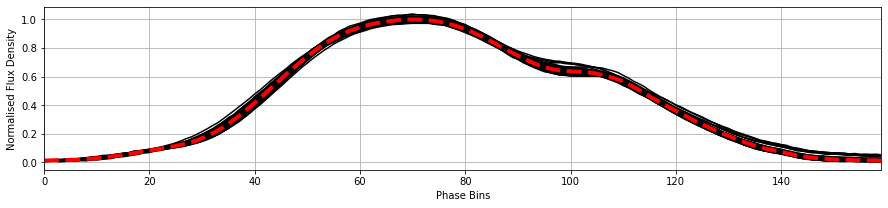

In [22]:
post_bin_match_median = np.zeros((aligned_data_norm.shape[0]))
for b in range(post_bin_match_median.shape[0]):
    post_bin_match_median[b] = np.median(aligned_data_norm[b,:])

ax = pvf.plot_profile(aligned_data_norm[window_begin:window_end,:])
ax.plot(post_bin_match_median[window_begin:window_end],'r--',linewidth=4)
ax.set_ylabel('Normalised Flux Density');

### (OPTIONAL) SAVE PLOTS OF ALL SURVIVING INDIVIDUAL PROFILES:

In [23]:
pvf.save_profiles(directory_name,aligned_data_norm[window_begin:window_end,:],mjd_remain,data.shape[0],'pulse_window_plots','Normalised Flux Density',template=post_bin_match_median[window_begin:window_end])

  0%|          | 0/71 [00:00<?, ?it/s]

### FIT A GAUSSIAN PROCESS MODEL TO EACH PHASE BIN IN THE PULSE WINDOW:

#### SELECT A GAUSSIAN PROCESS LENGTH SCALE IN DAYS:

In [24]:
gp_len_scale = 100

#### FIT THE MODEL:

In [25]:
gp_data = np.zeros((window_end-window_begin,int(mjd_remain[-1])-int(mjd_remain[0]))) 
gp_var = np.zeros((window_end-window_begin,int(mjd_remain[-1])-int(mjd_remain[0])))
all_profile_residuals = np.zeros((window_end-window_begin,aligned_data_norm.shape[1]))
gp_mjds = np.zeros((int(mjd_remain[-1])-int(mjd_remain[0])))
x_pred = np.arange(int(mjd_remain[0]), int(mjd_remain[-1]),1)
all_noise = np.zeros((window_end-window_begin,aligned_data_norm.shape[1]))

for g in tqdm_notebook(range(window_end-window_begin)):
    y_profile_residuals = (aligned_data_norm[window_begin+g,:] - post_bin_match_median[window_begin+g])/rms
    y_noise = np.std(y_profile_residuals)* np.ones_like(mjd_remain)    
    kernel = np.var(y_profile_residuals) * kernels.ExpSquaredKernel(gp_len_scale)
    gp = george.GP(kernel)
    gp.compute(mjd_remain, y_noise)
    pred, pred_var = gp.predict(y_profile_residuals, x_pred, return_var=True)

    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(y_profile_residuals)

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(y_profile_residuals)

    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
    gp.set_parameter_vector(result.x)
    
    pred, pred_var = gp.predict(y_profile_residuals, x_pred, return_var=True)
    
    
    gp_data[g,:] = pred 
    gp_var[g,:] = pred_var
    all_profile_residuals[g,:] = y_profile_residuals
    all_noise[g,:] = y_noise

gp_mjds[:] = x_pred

/tmp/ipykernel_40054/2612204947.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for g in tqdm_notebook(range(window_end-window_begin)):


  0%|          | 0/160 [00:00<?, ?it/s]

### (OPTIONAL) VIEW EACH THE GAUSSIAN PROCESS MODELS:

/tmp/ipykernel_40054/2450551917.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(gp_data.shape[0])):


  0%|          | 0/160 [00:00<?, ?it/s]

PHASE BIN: 0


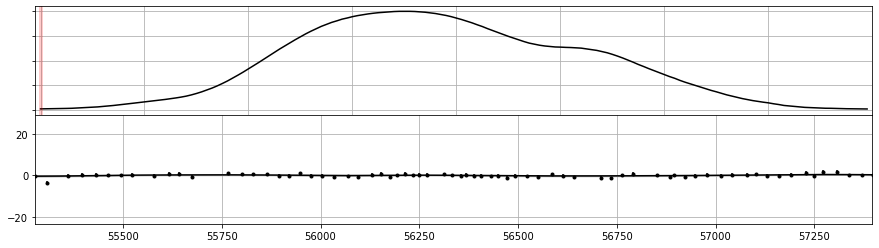

PHASE BIN: 1


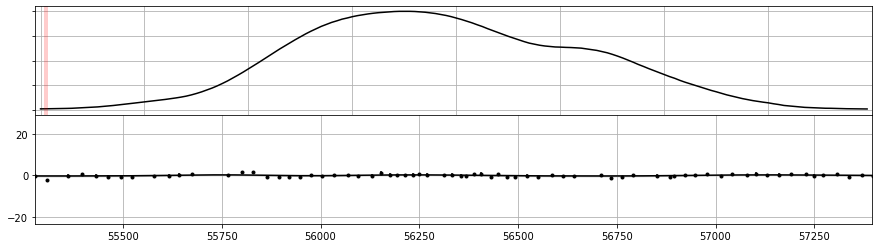

PHASE BIN: 2


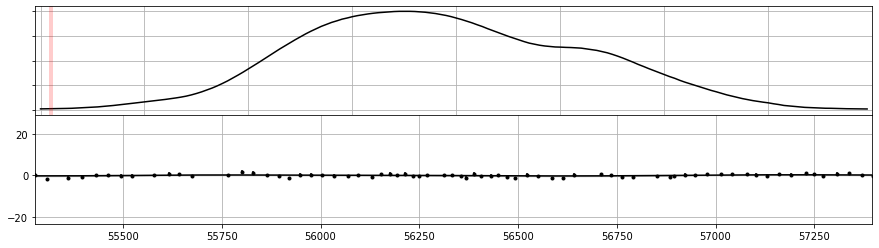

PHASE BIN: 3


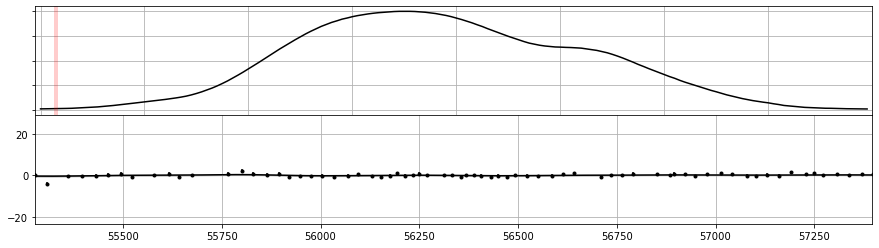

PHASE BIN: 4


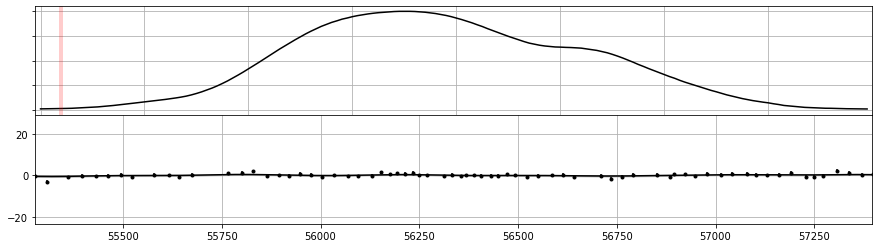

PHASE BIN: 5


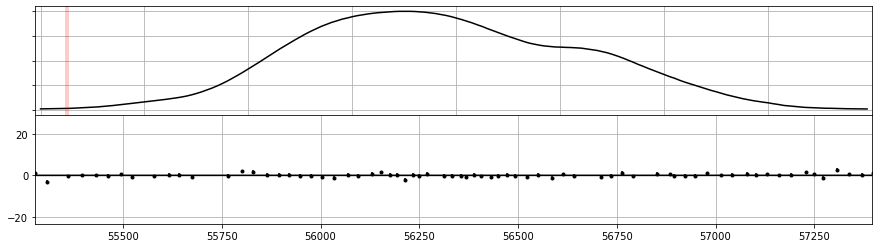

PHASE BIN: 6


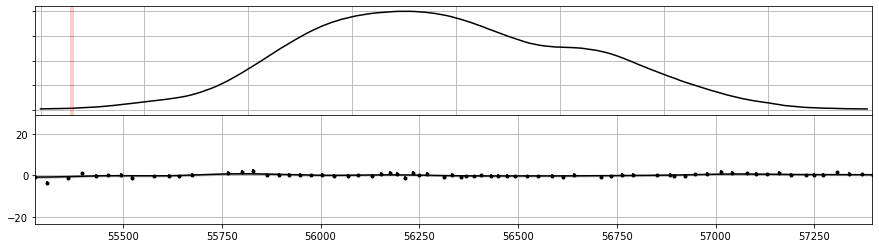

PHASE BIN: 7


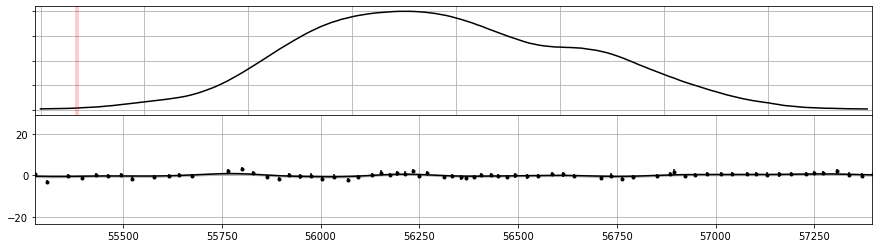

PHASE BIN: 8


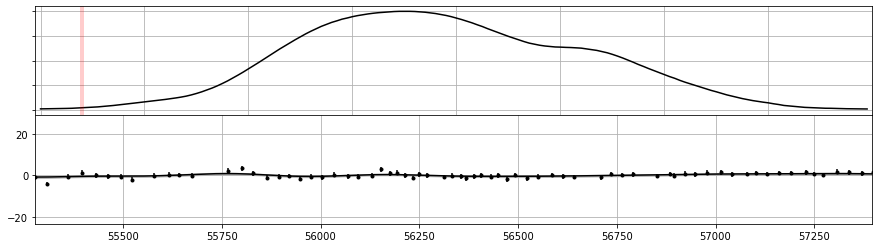

PHASE BIN: 9


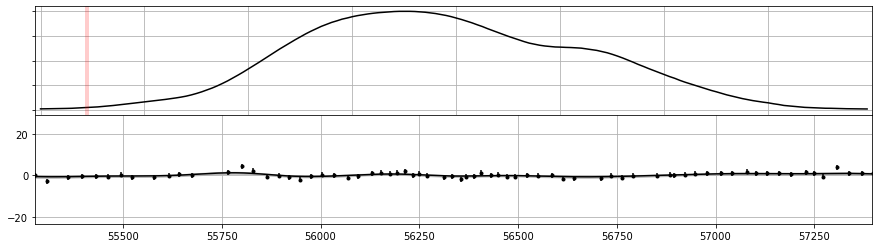

PHASE BIN: 10


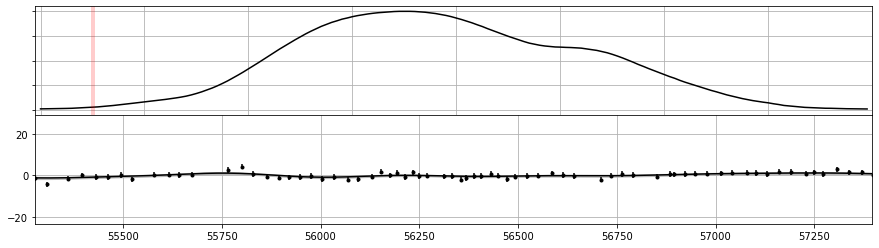

PHASE BIN: 11


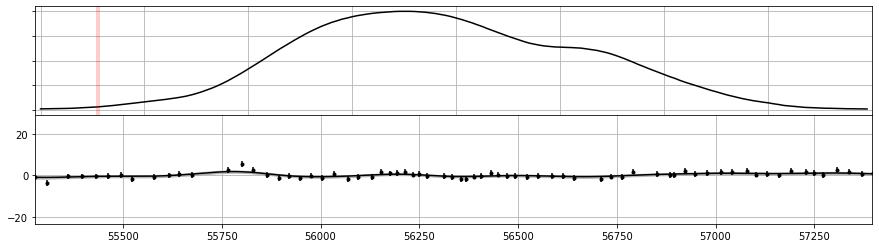

PHASE BIN: 12


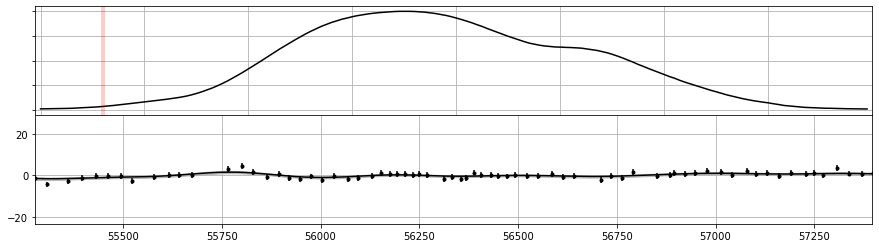

PHASE BIN: 13


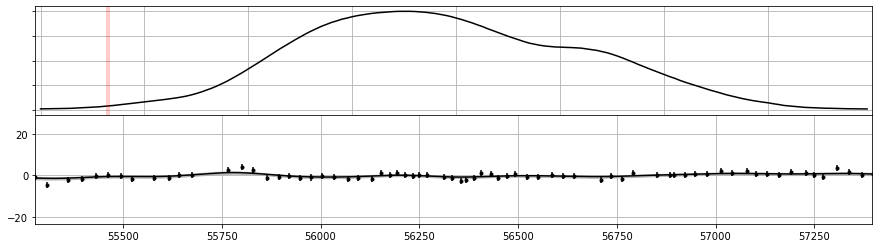

PHASE BIN: 14


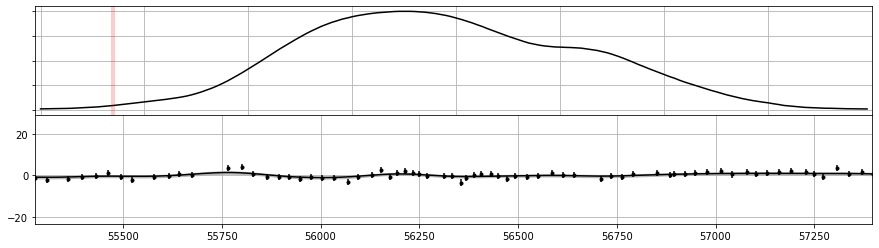

PHASE BIN: 15


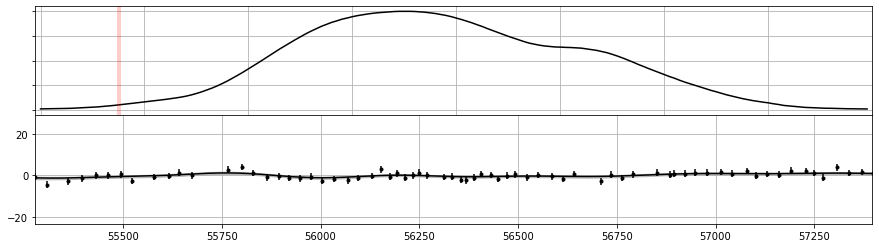

PHASE BIN: 16


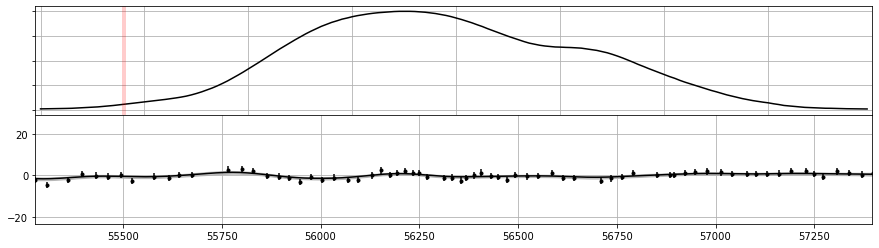

PHASE BIN: 17


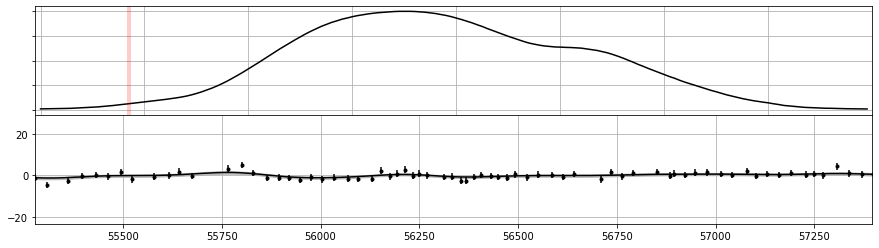

PHASE BIN: 18


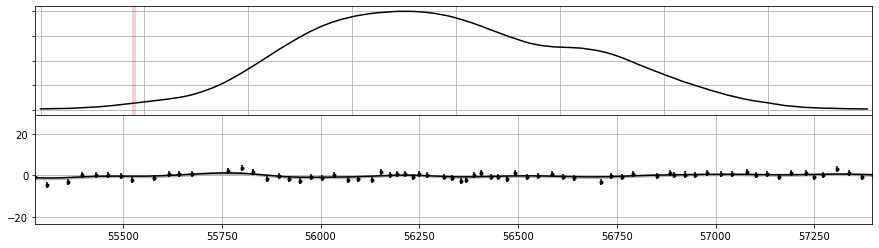

PHASE BIN: 19


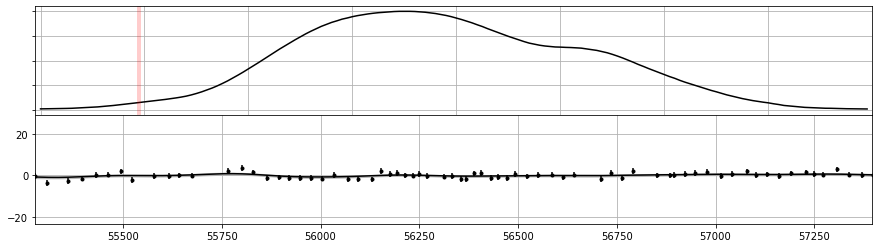

PHASE BIN: 20


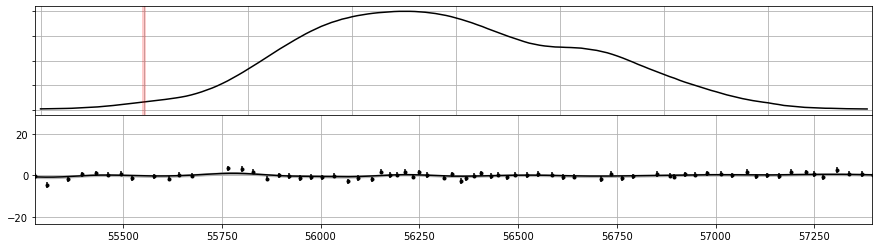

PHASE BIN: 21


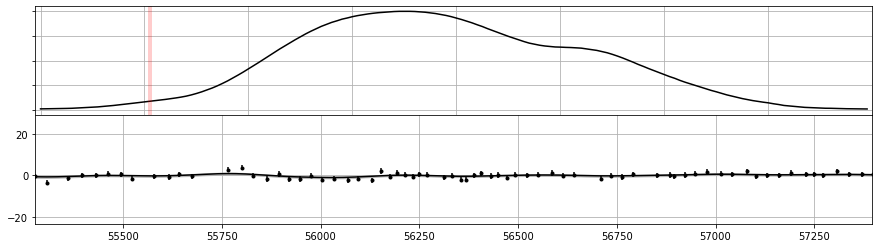

PHASE BIN: 22


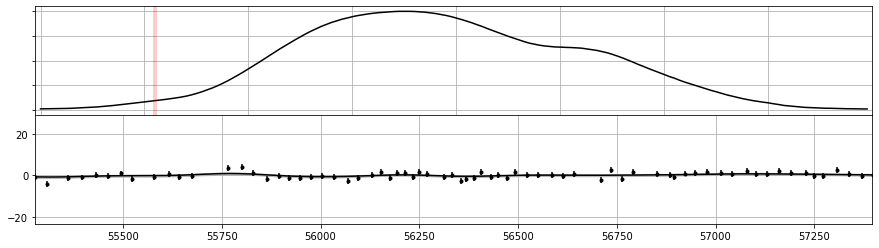

PHASE BIN: 23


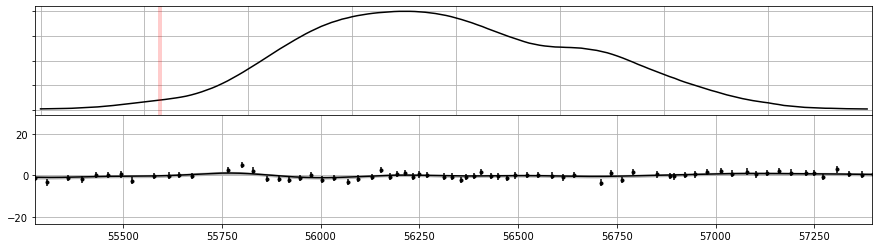

PHASE BIN: 24


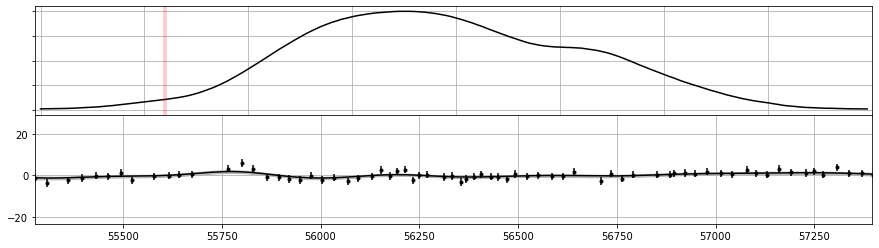

PHASE BIN: 25


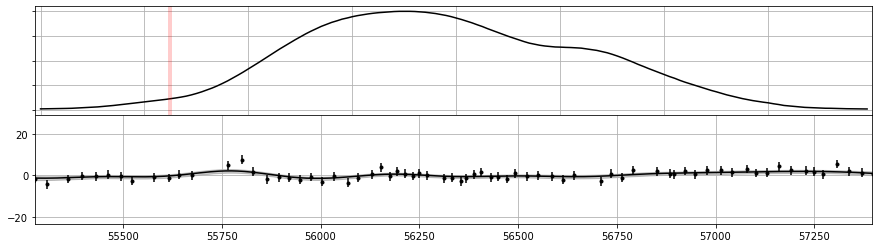

PHASE BIN: 26


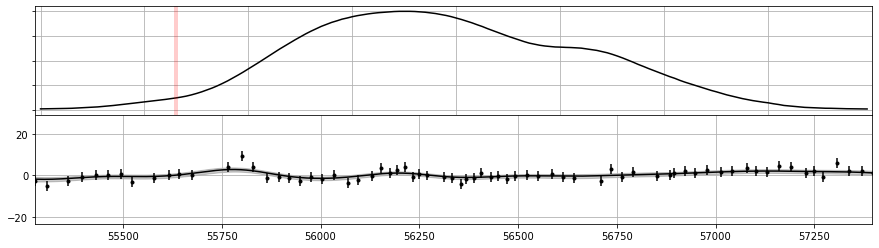

PHASE BIN: 27


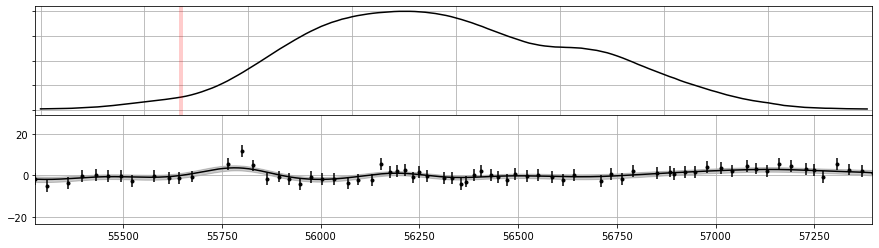

PHASE BIN: 28


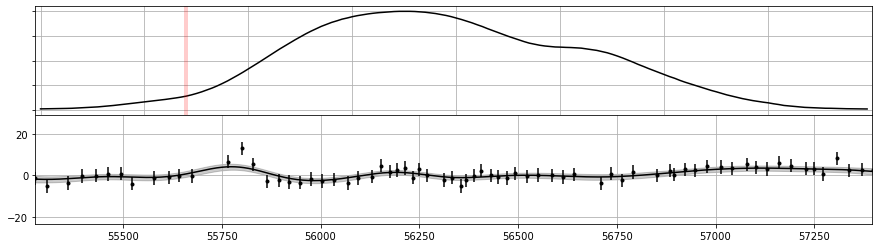

PHASE BIN: 29


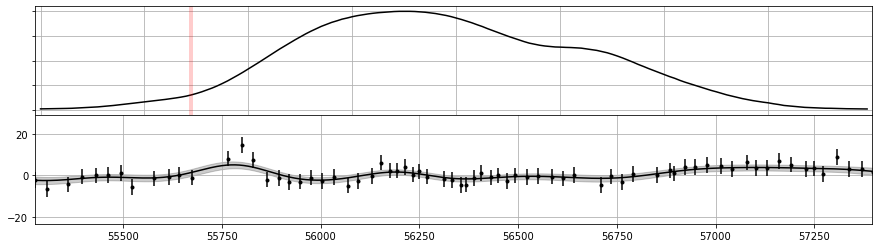

PHASE BIN: 30


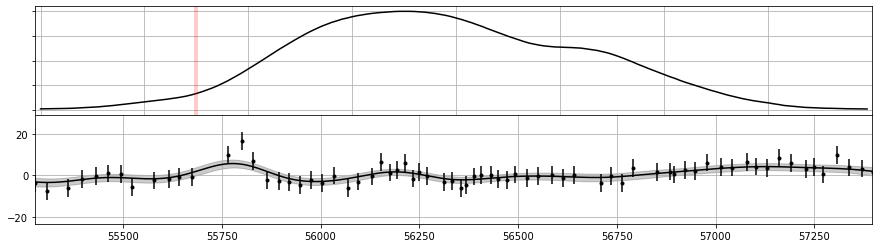

PHASE BIN: 31


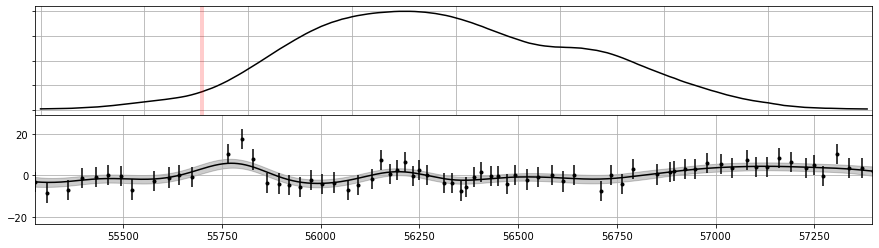

PHASE BIN: 32


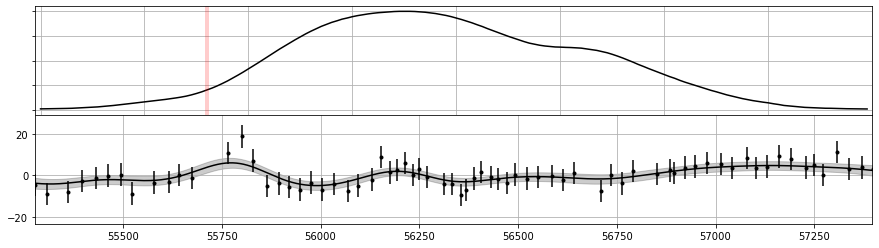

PHASE BIN: 33


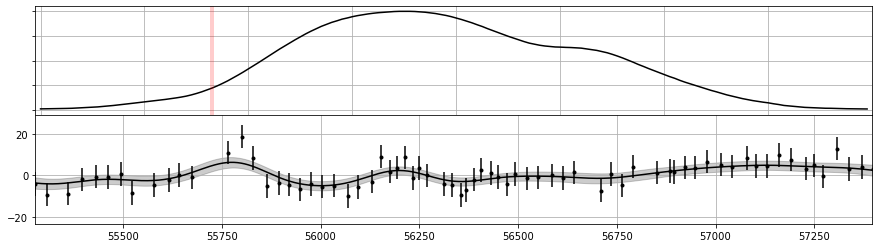

PHASE BIN: 34


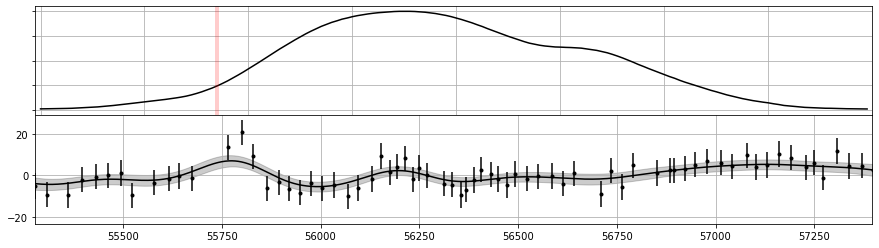

PHASE BIN: 35


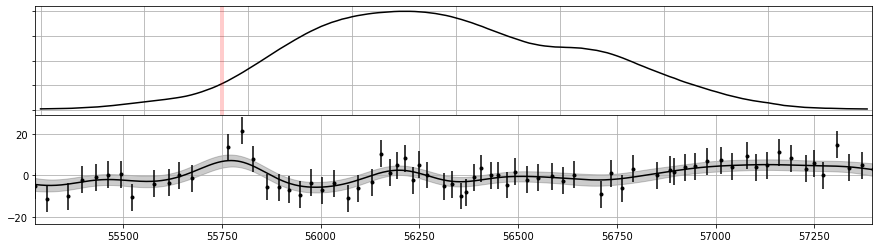

PHASE BIN: 36


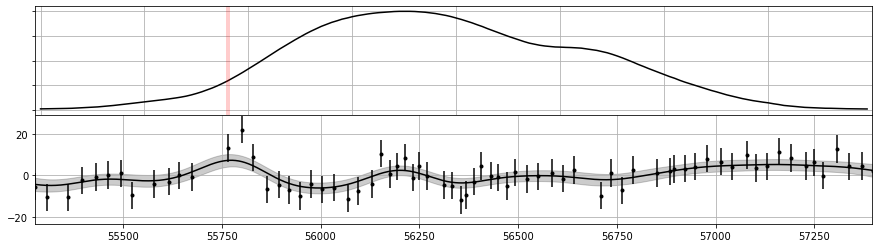

PHASE BIN: 37


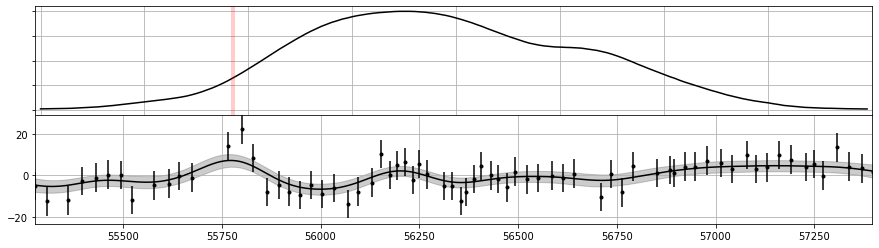

PHASE BIN: 38


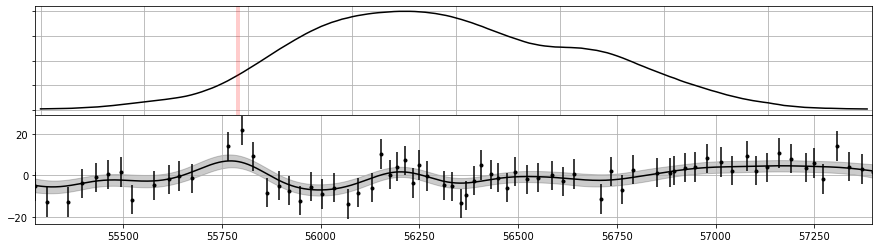

PHASE BIN: 39


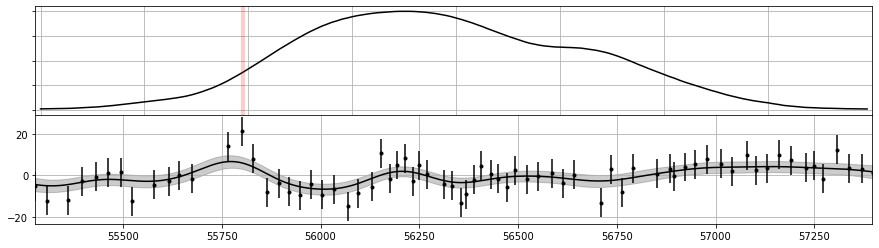

PHASE BIN: 40


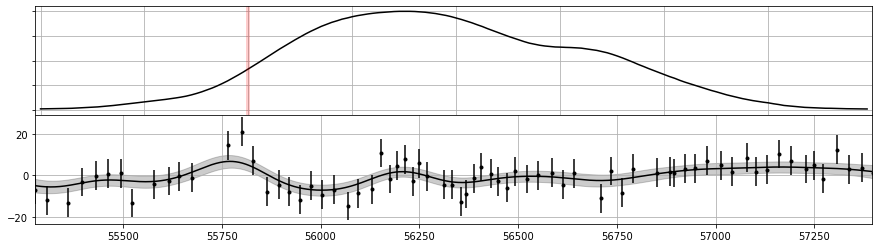

PHASE BIN: 41


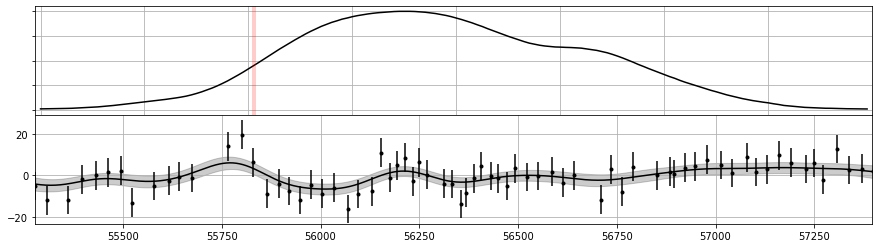

PHASE BIN: 42


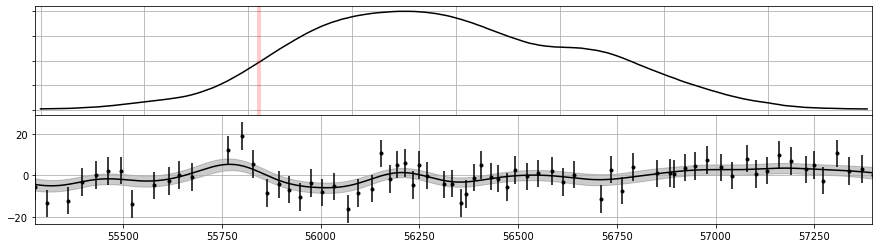

PHASE BIN: 43


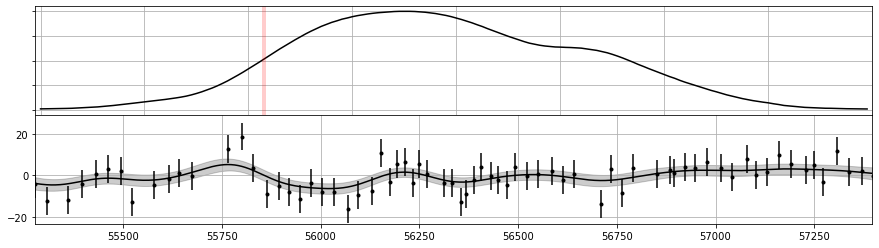

PHASE BIN: 44


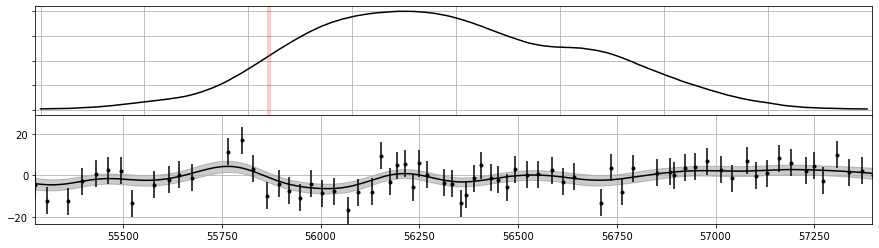

PHASE BIN: 45


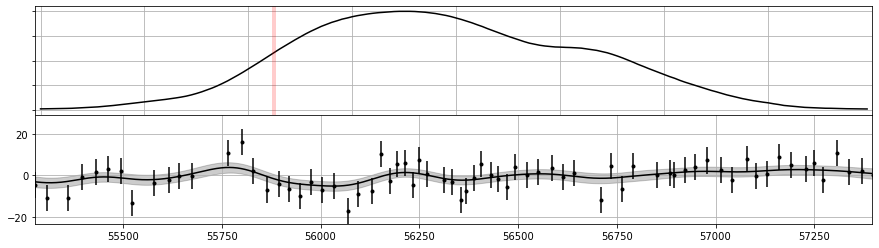

PHASE BIN: 46


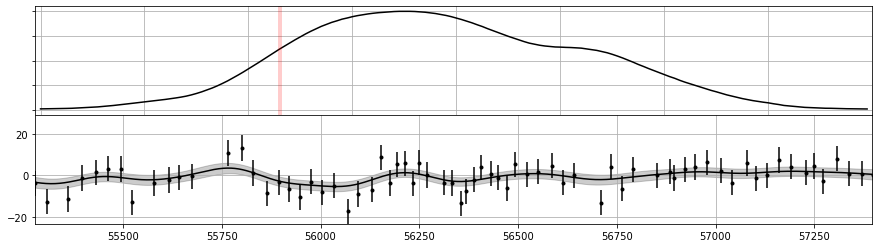

PHASE BIN: 47


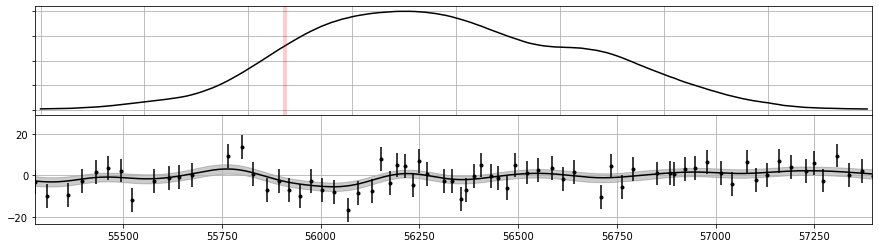

PHASE BIN: 48


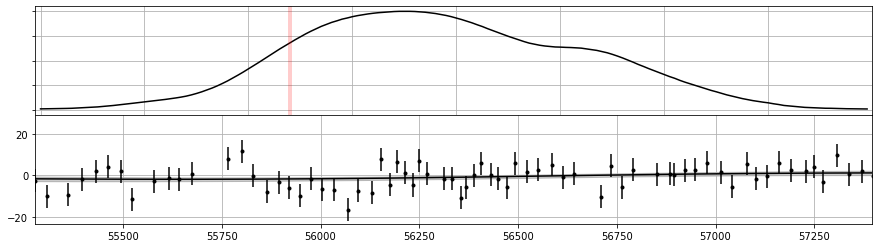

PHASE BIN: 49


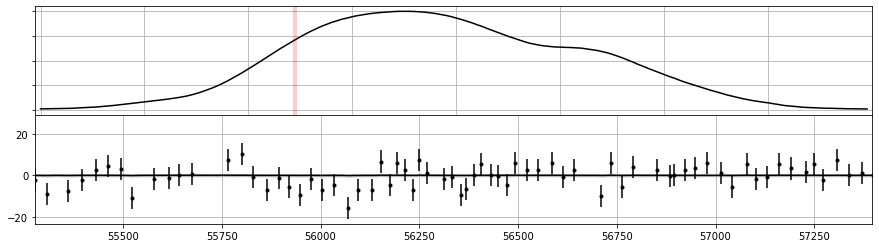

PHASE BIN: 50


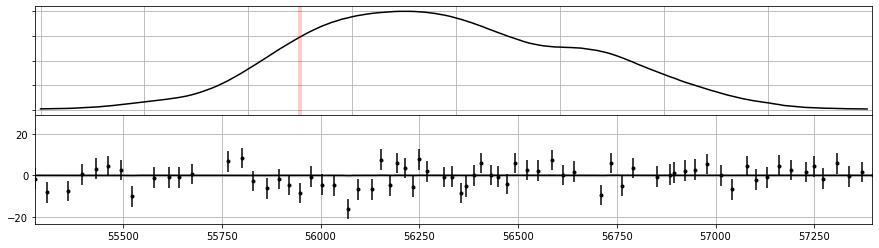

PHASE BIN: 51


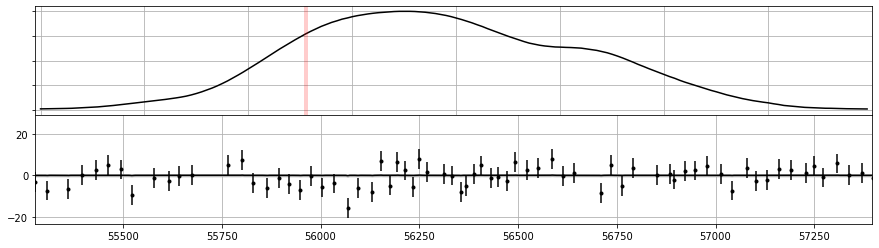

PHASE BIN: 52


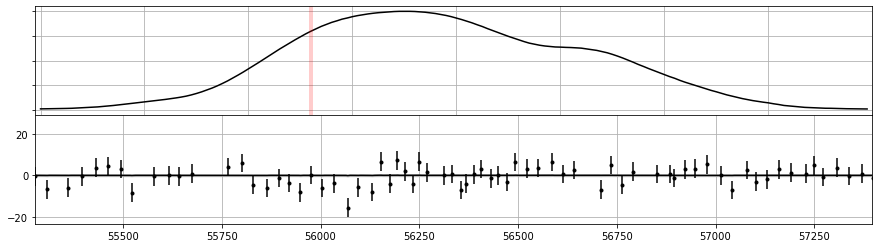

PHASE BIN: 53


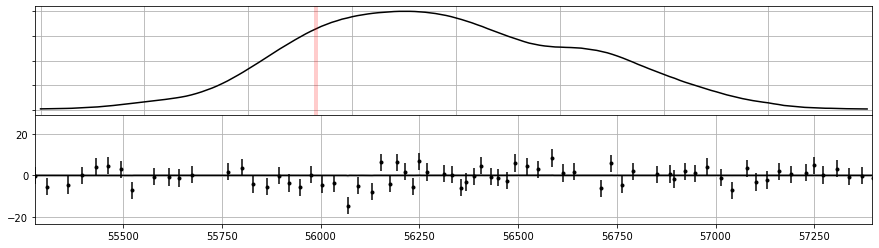

PHASE BIN: 54


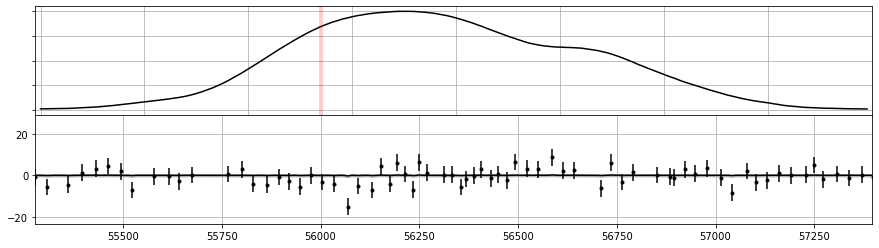

PHASE BIN: 55


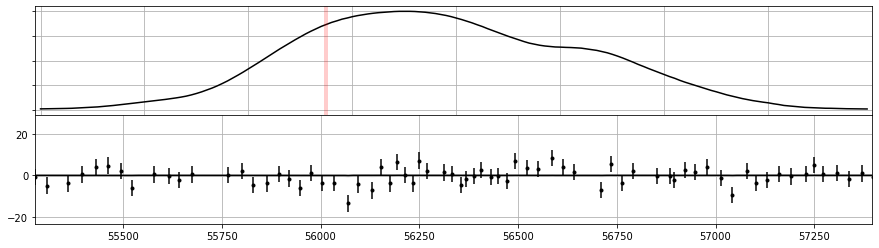

PHASE BIN: 56


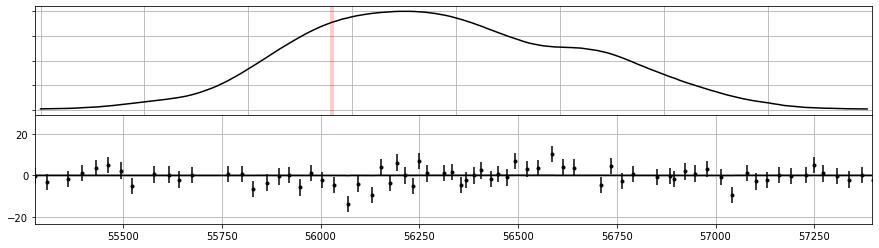

PHASE BIN: 57


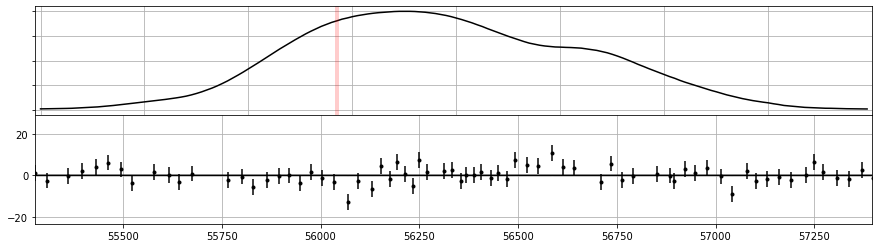

PHASE BIN: 58


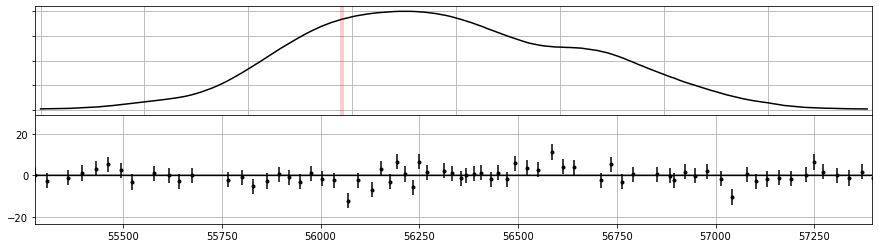

PHASE BIN: 59


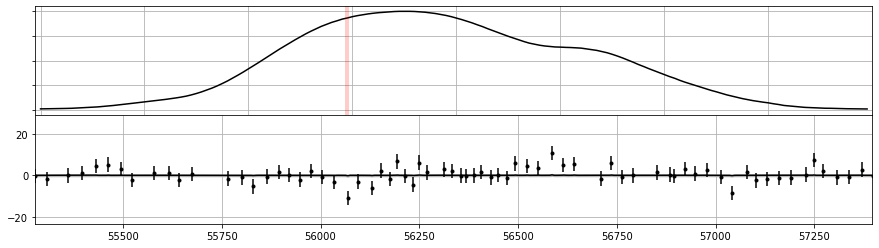

PHASE BIN: 60


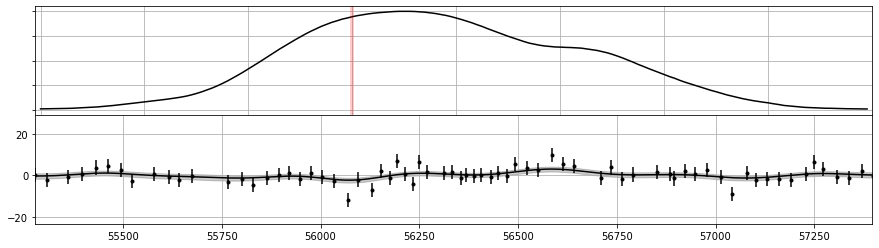

PHASE BIN: 61


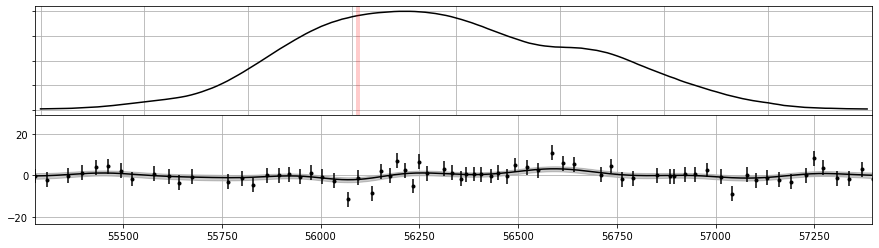

PHASE BIN: 62


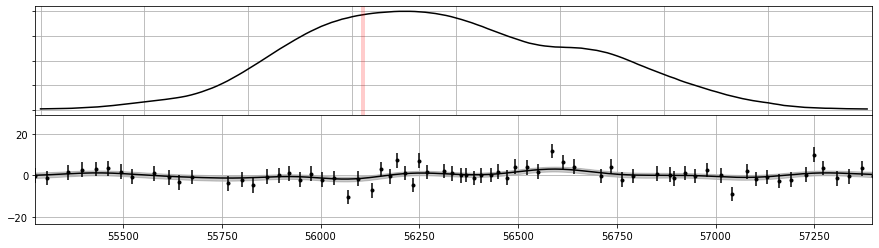

PHASE BIN: 63


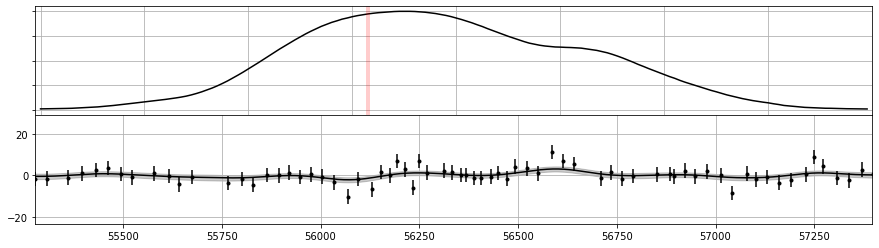

PHASE BIN: 64


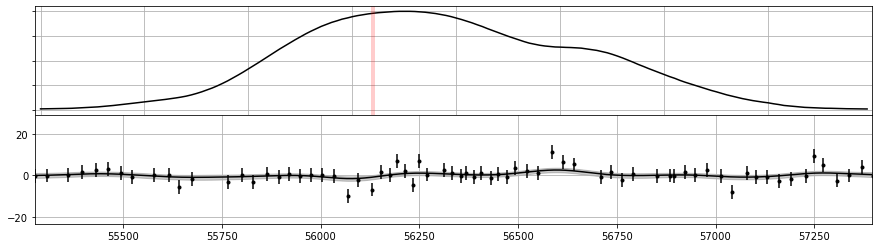

PHASE BIN: 65


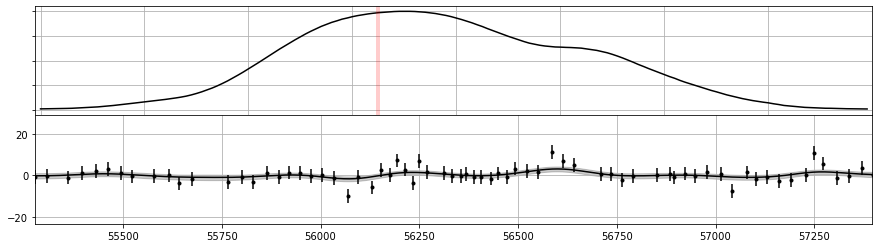

PHASE BIN: 66


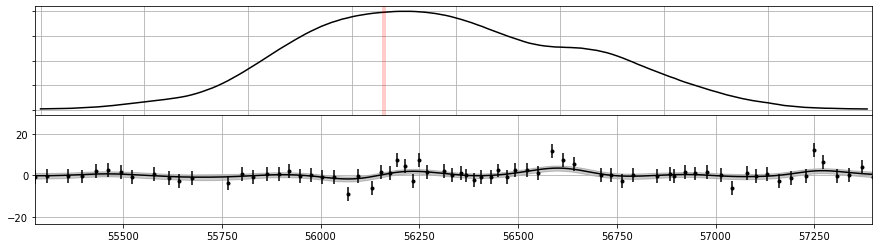

PHASE BIN: 67


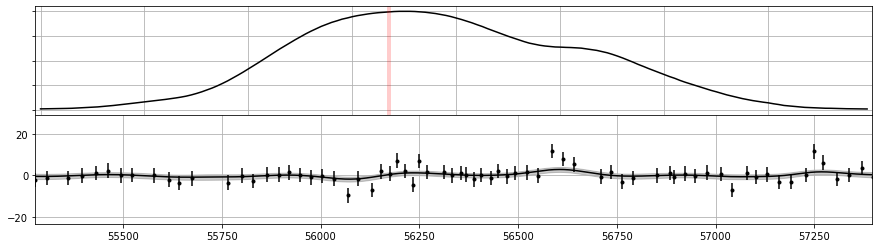

PHASE BIN: 68


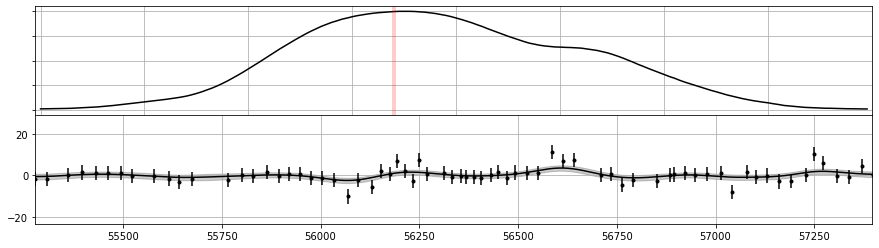

PHASE BIN: 69


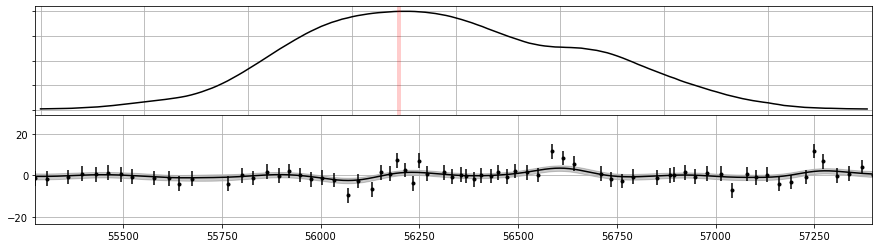

PHASE BIN: 70


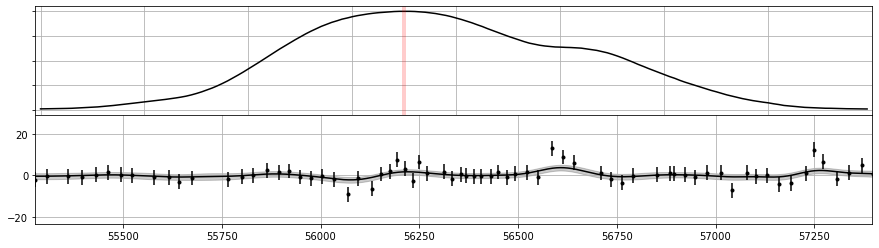

PHASE BIN: 71


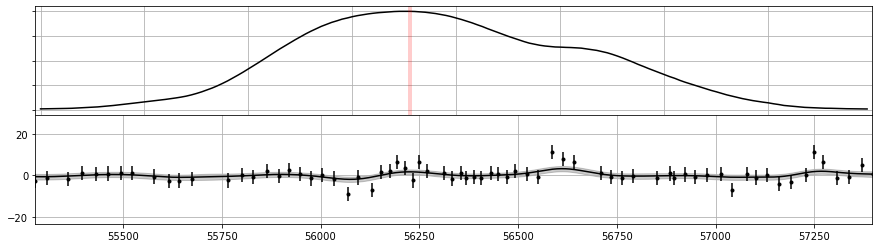

PHASE BIN: 72


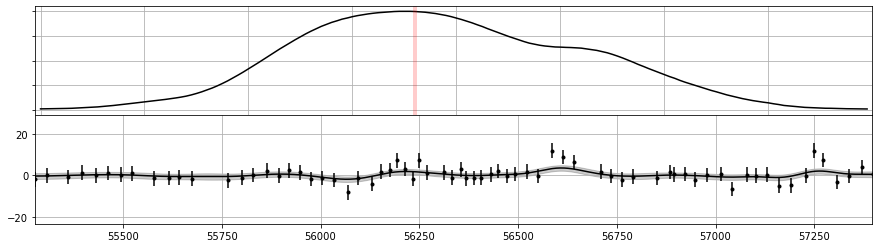

PHASE BIN: 73


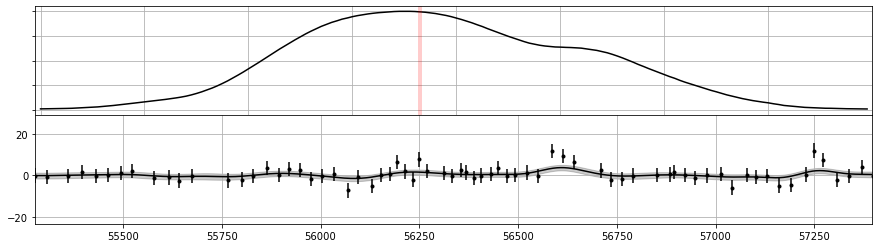

PHASE BIN: 74


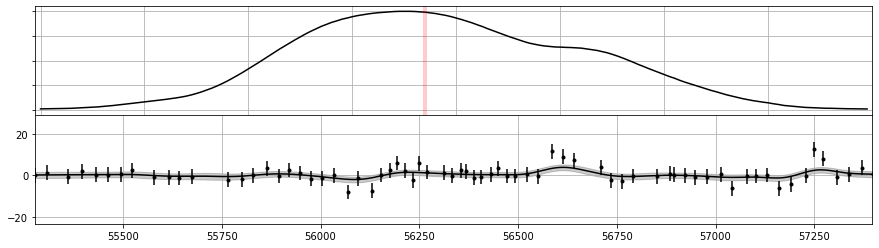

PHASE BIN: 75


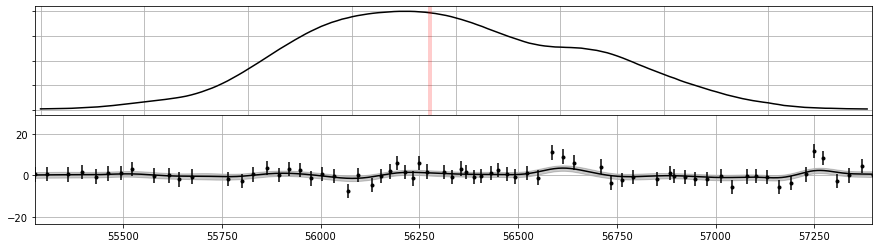

PHASE BIN: 76


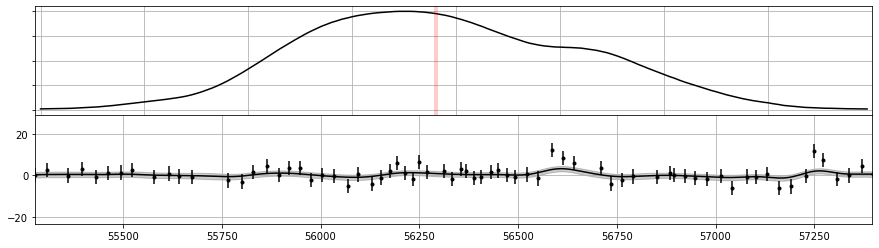

PHASE BIN: 77


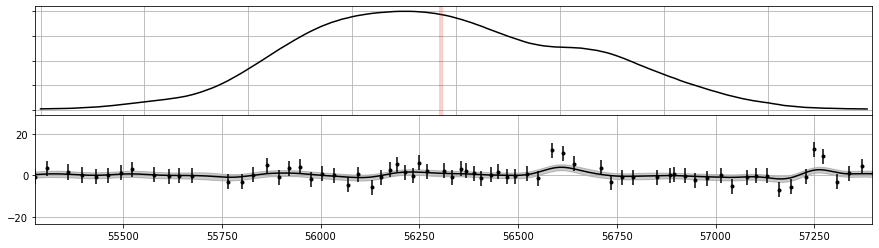

PHASE BIN: 78


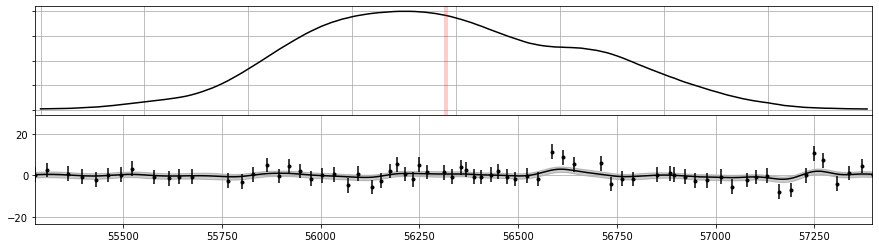

PHASE BIN: 79


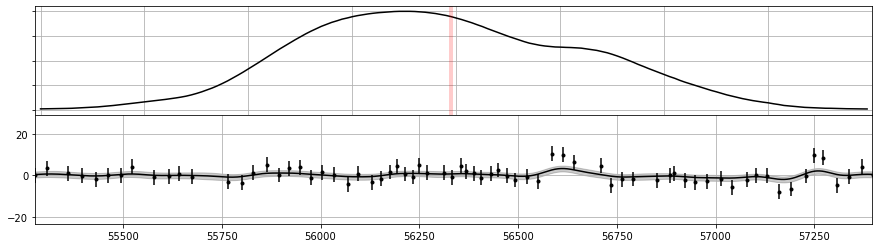

PHASE BIN: 80


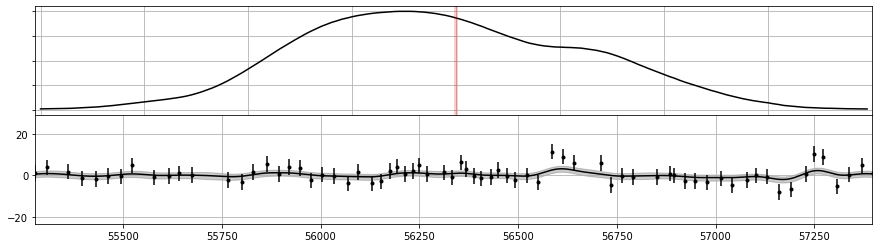

PHASE BIN: 81


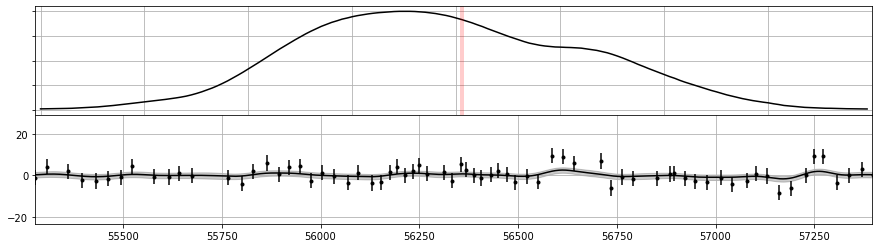

PHASE BIN: 82


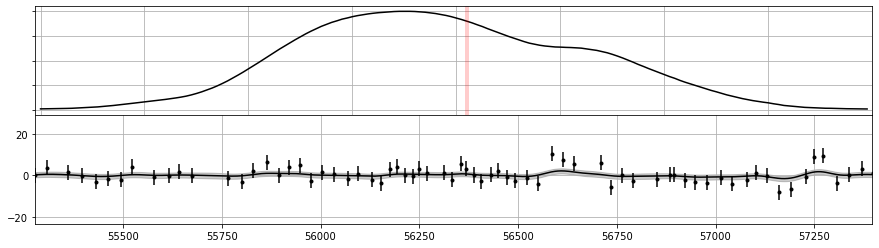

PHASE BIN: 83


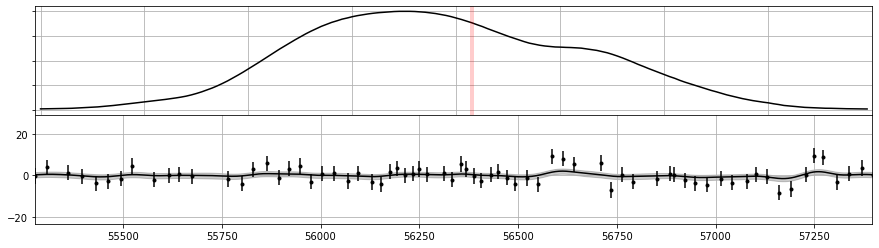

PHASE BIN: 84


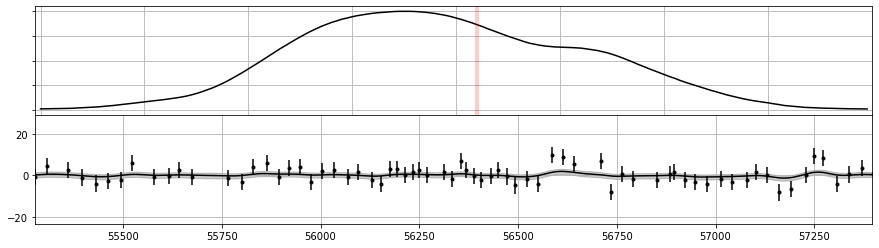

PHASE BIN: 85


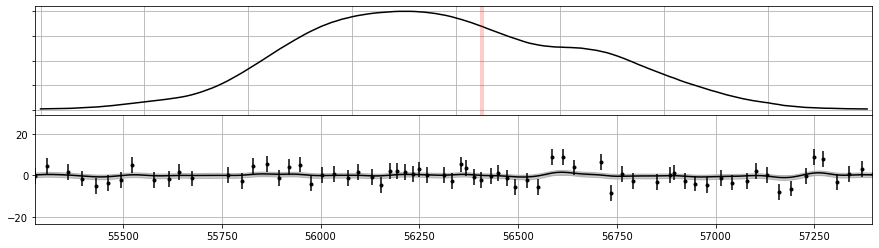

PHASE BIN: 86


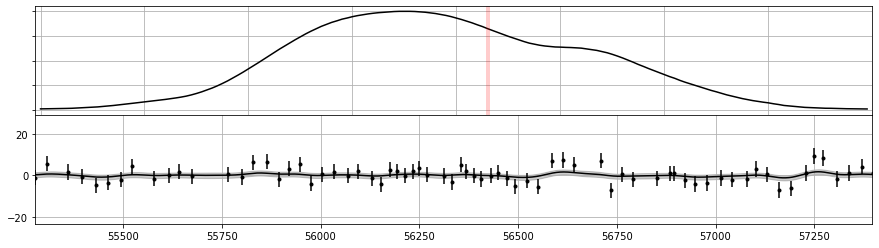

PHASE BIN: 87


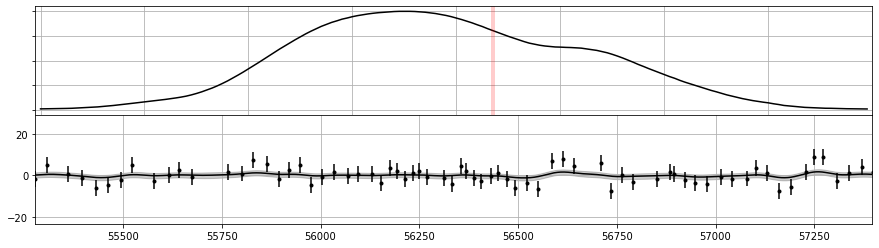

PHASE BIN: 88


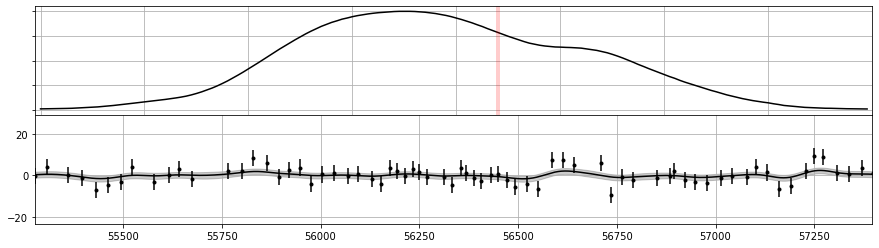

PHASE BIN: 89


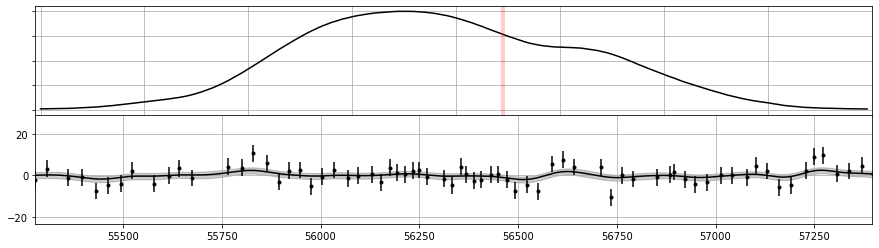

PHASE BIN: 90


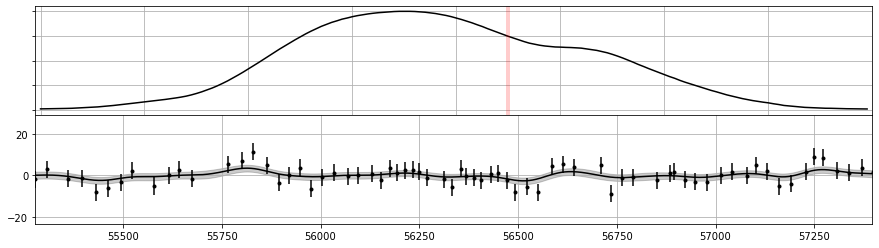

PHASE BIN: 91


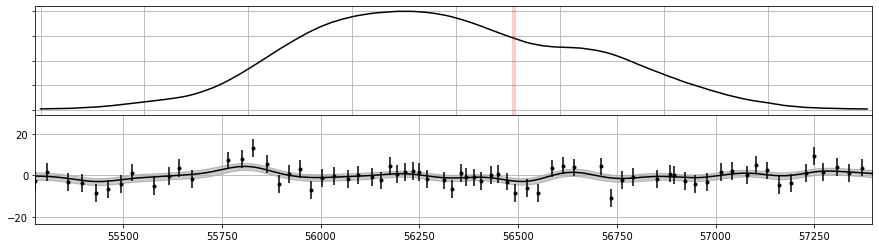

PHASE BIN: 92


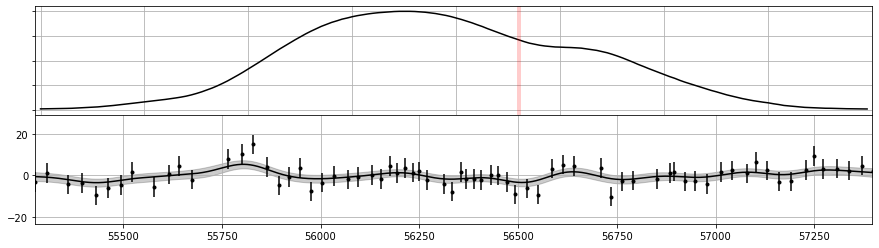

PHASE BIN: 93


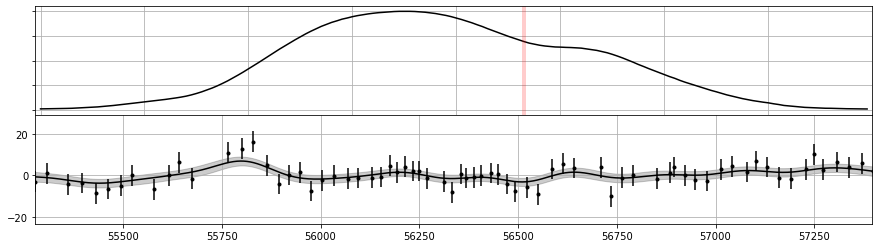

PHASE BIN: 94


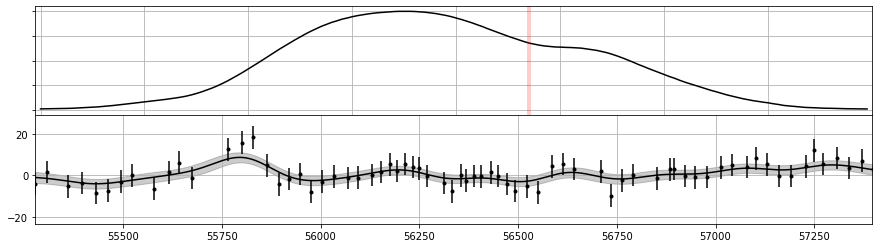

PHASE BIN: 95


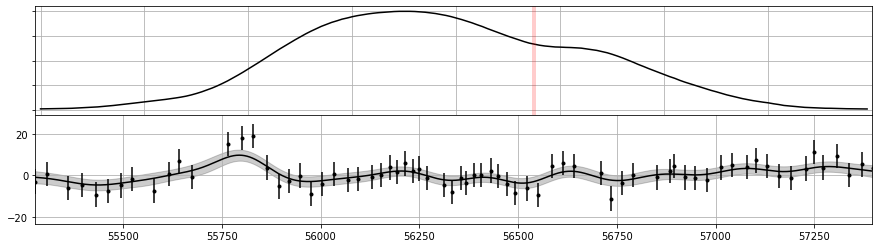

PHASE BIN: 96


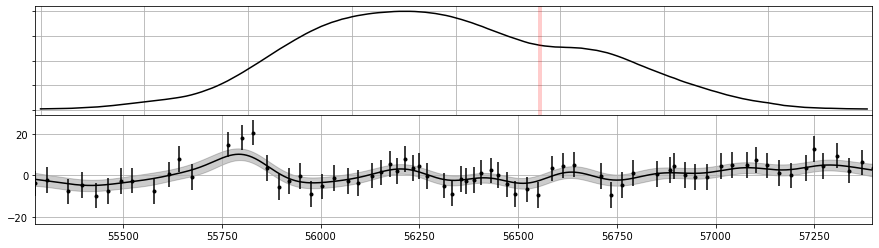

PHASE BIN: 97


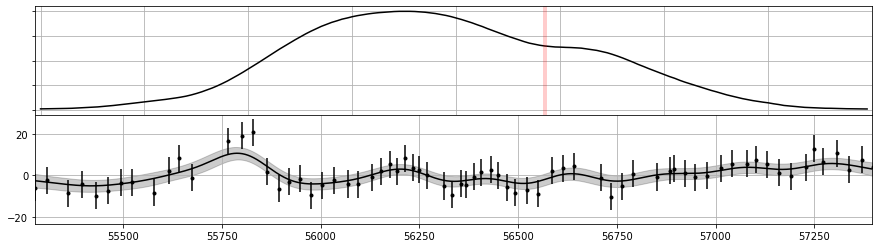

PHASE BIN: 98


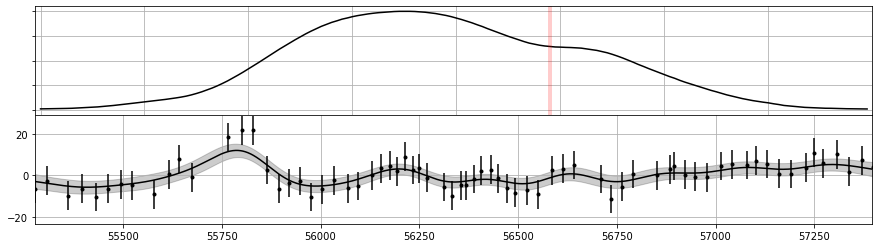

PHASE BIN: 99


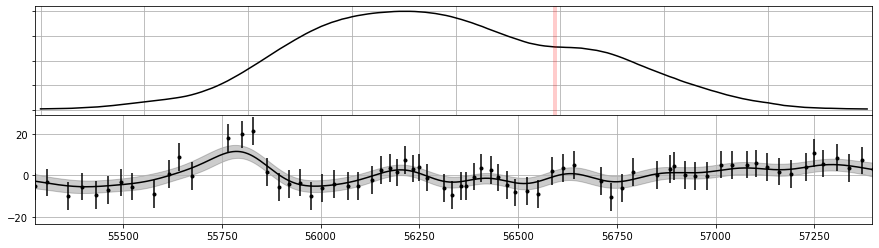

PHASE BIN: 100


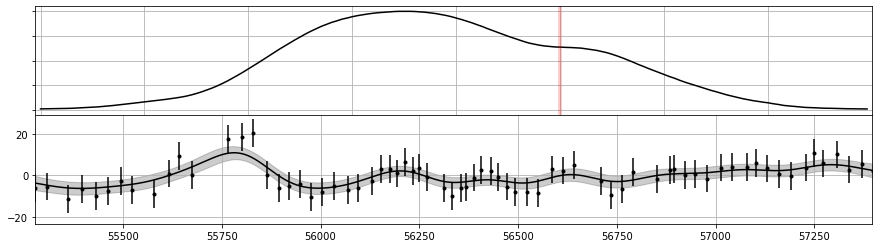

PHASE BIN: 101


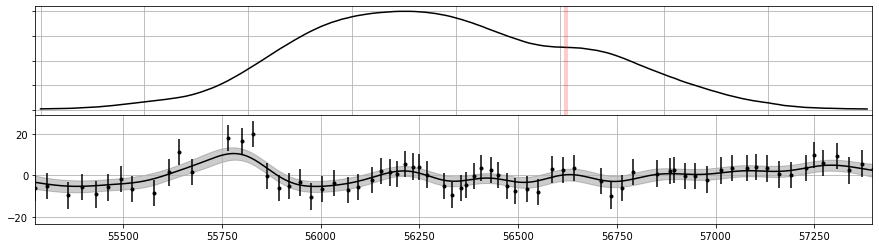

PHASE BIN: 102


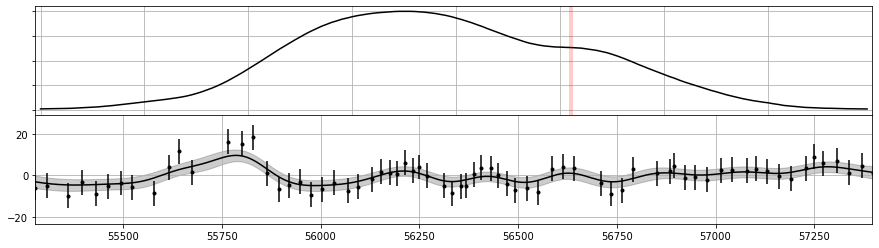

PHASE BIN: 103


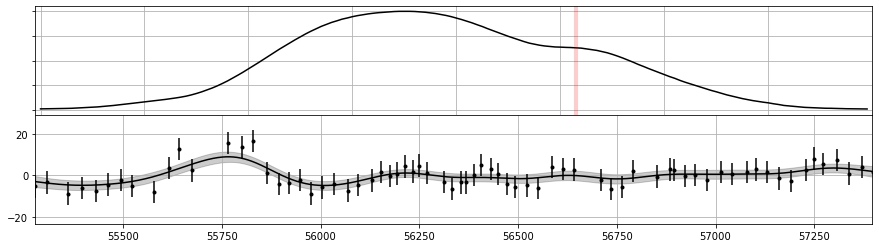

PHASE BIN: 104


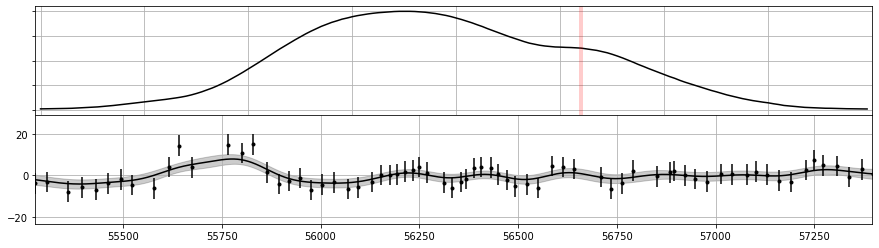

PHASE BIN: 105


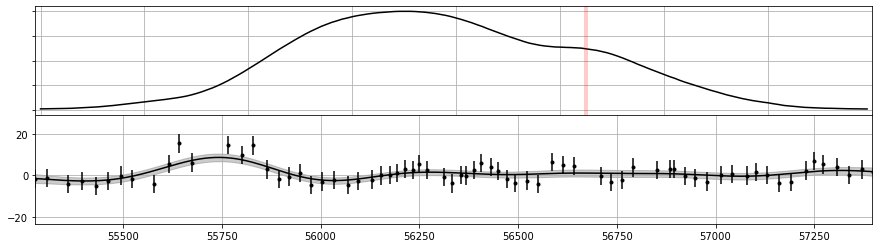

PHASE BIN: 106


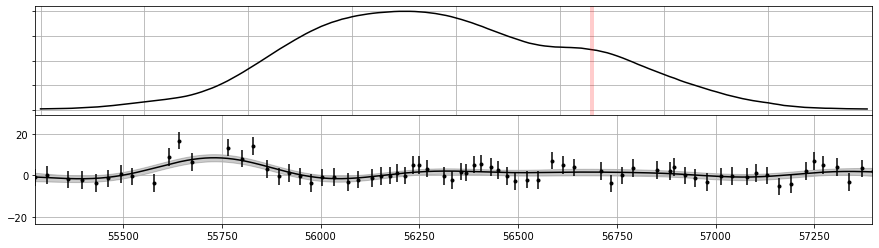

PHASE BIN: 107


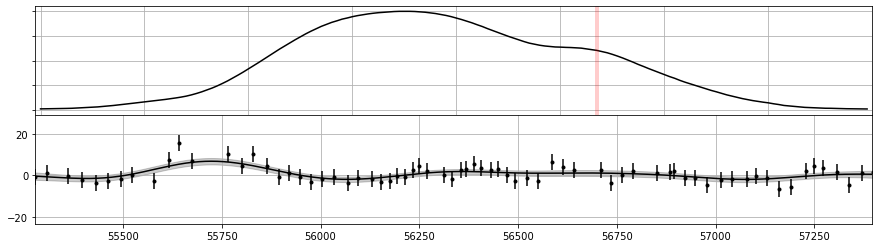

PHASE BIN: 108


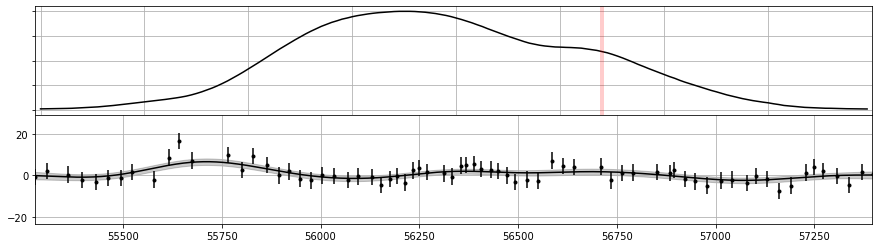

PHASE BIN: 109


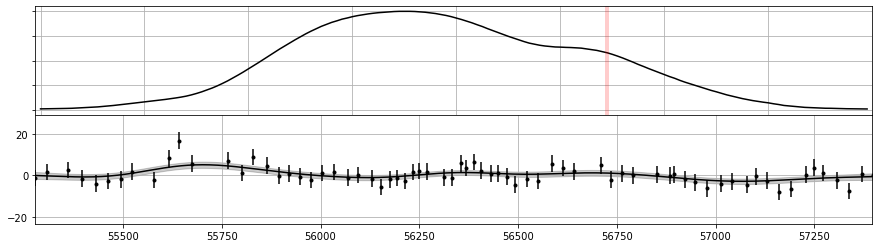

PHASE BIN: 110


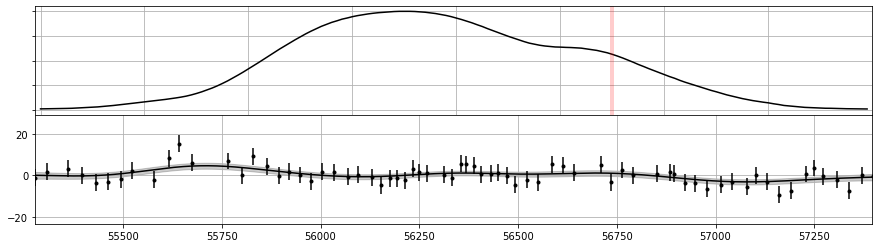

PHASE BIN: 111


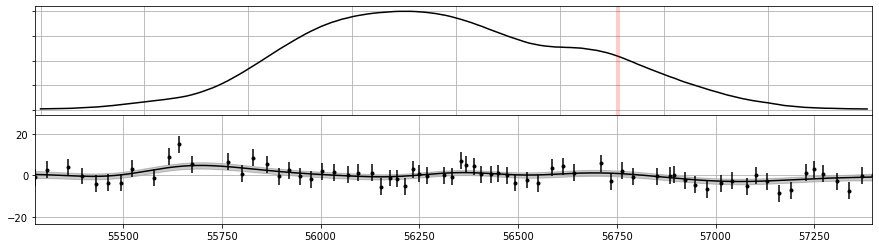

PHASE BIN: 112


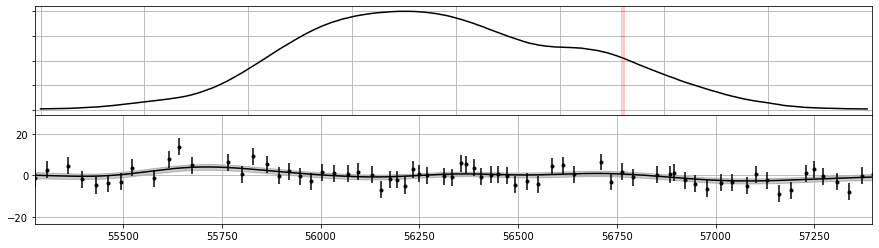

PHASE BIN: 113


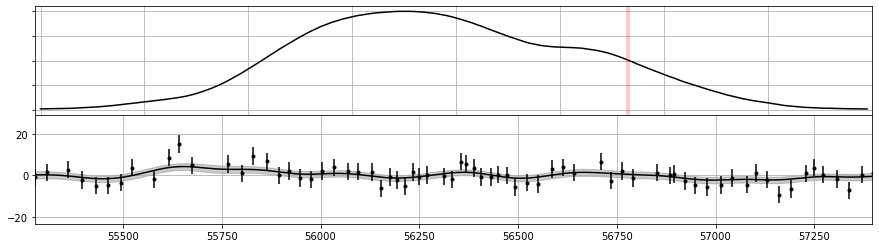

PHASE BIN: 114


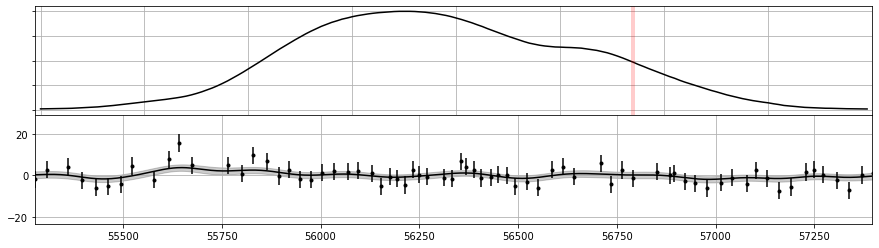

PHASE BIN: 115


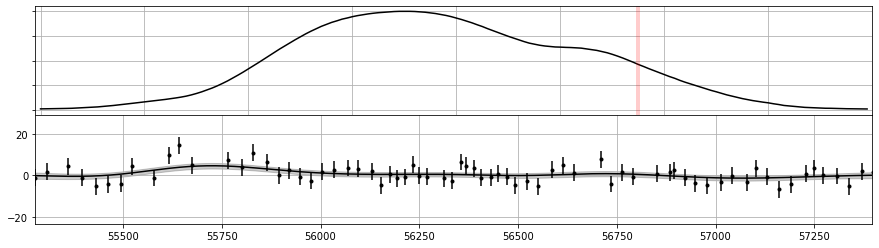

PHASE BIN: 116


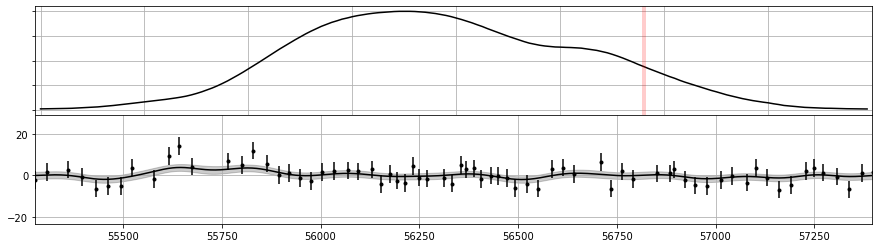

PHASE BIN: 117


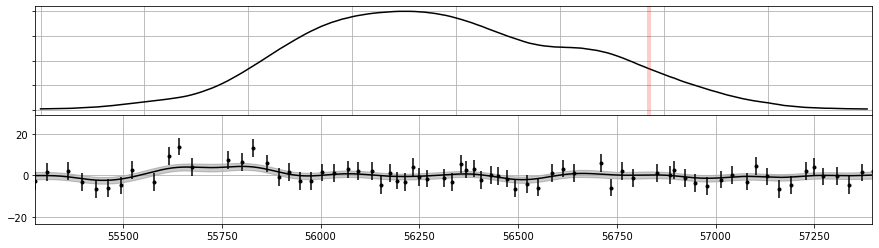

PHASE BIN: 118


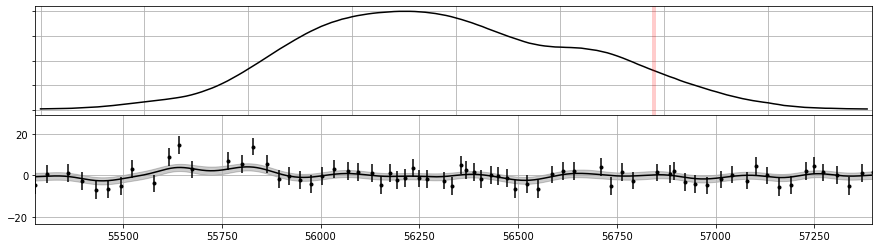

PHASE BIN: 119


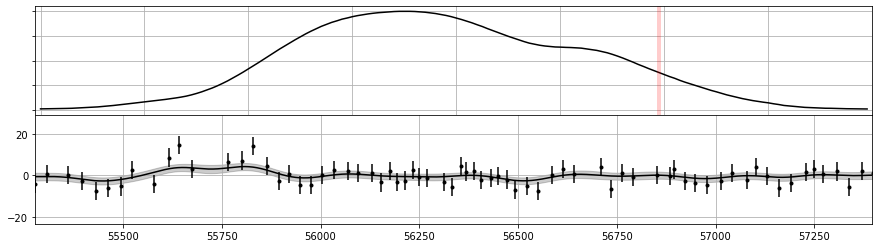

PHASE BIN: 120


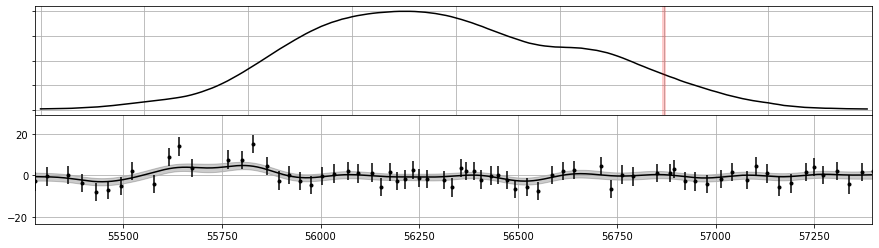

PHASE BIN: 121


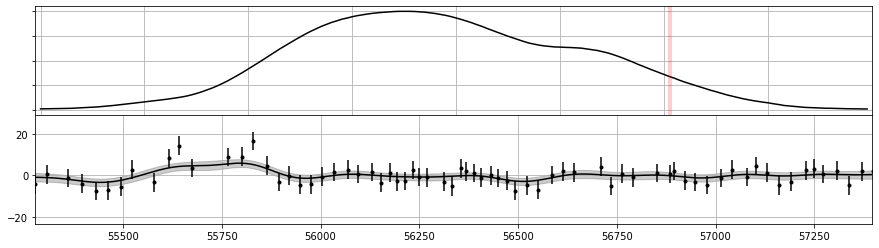

PHASE BIN: 122


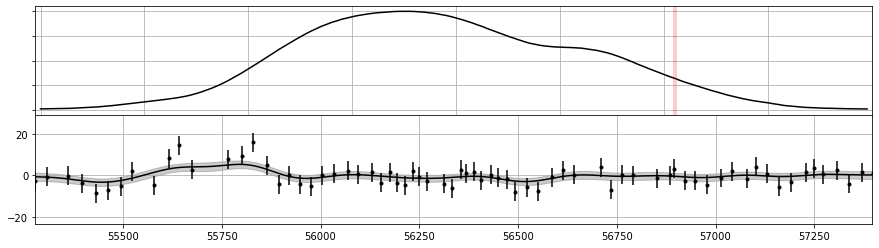

PHASE BIN: 123


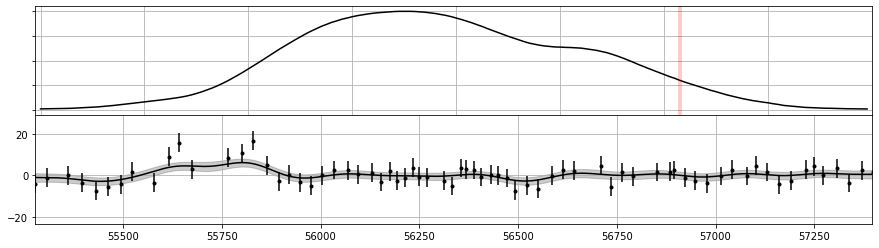

PHASE BIN: 124


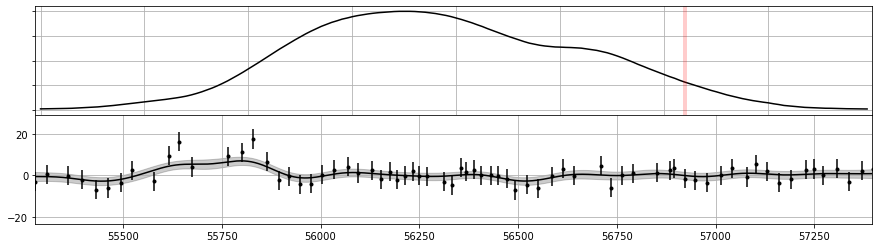

PHASE BIN: 125


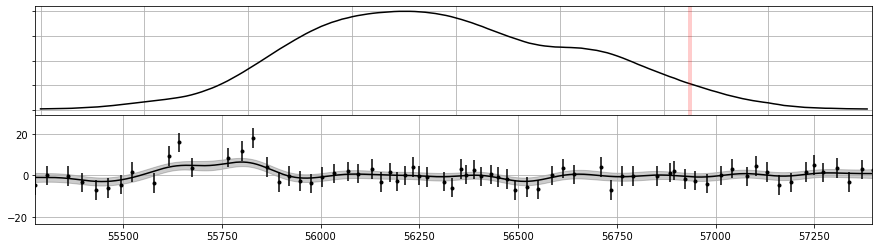

PHASE BIN: 126


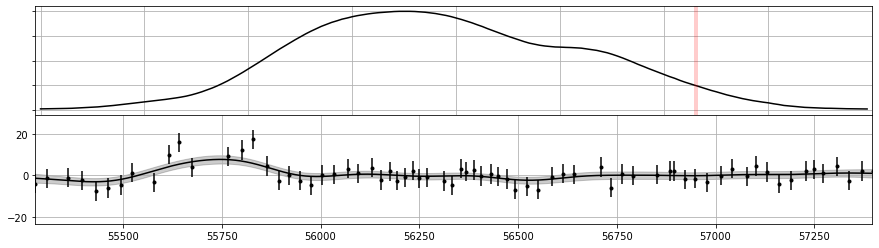

PHASE BIN: 127


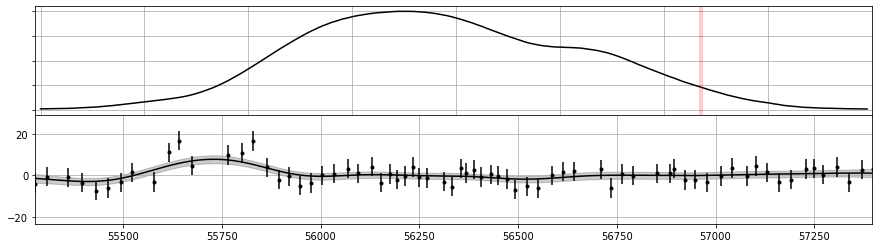

PHASE BIN: 128


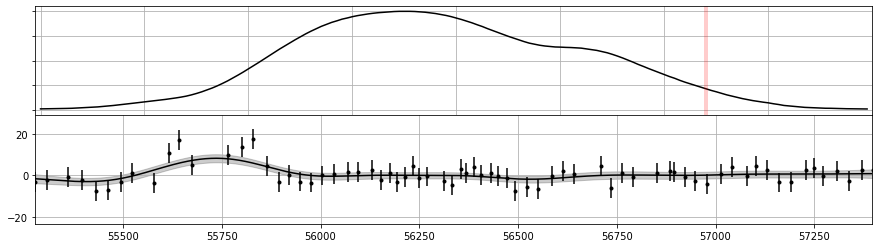

PHASE BIN: 129


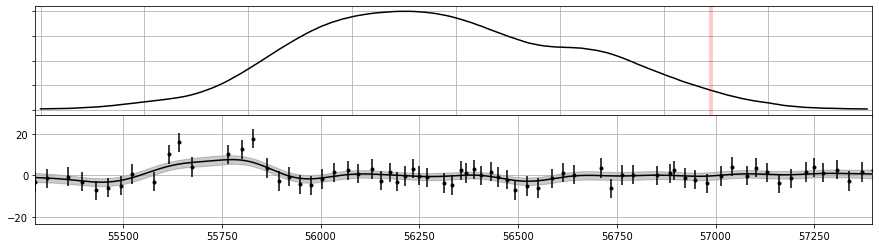

PHASE BIN: 130


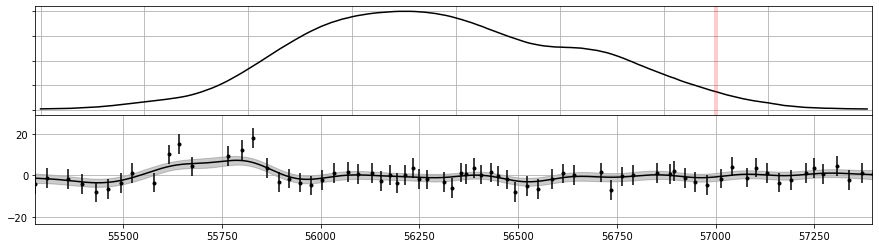

PHASE BIN: 131


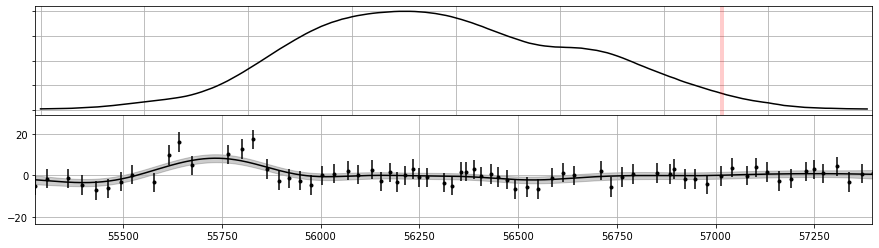

PHASE BIN: 132


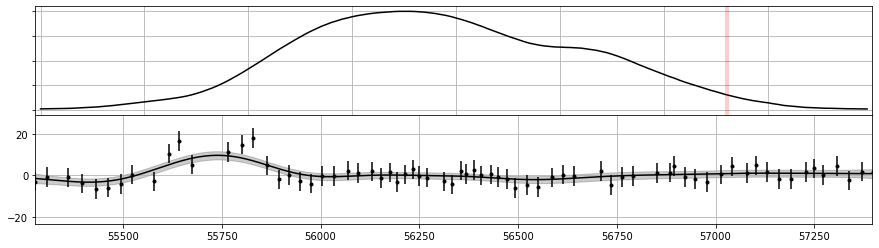

PHASE BIN: 133


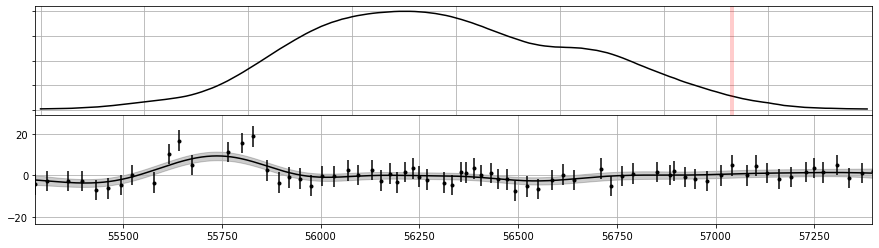

PHASE BIN: 134


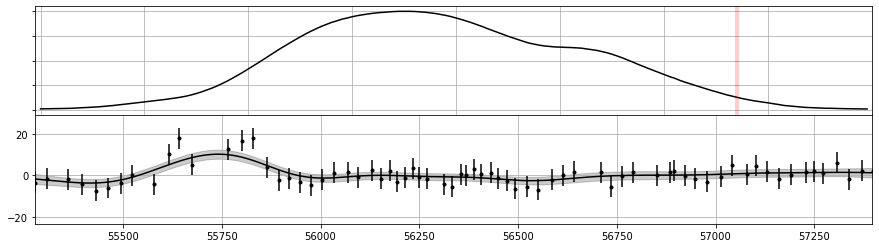

PHASE BIN: 135


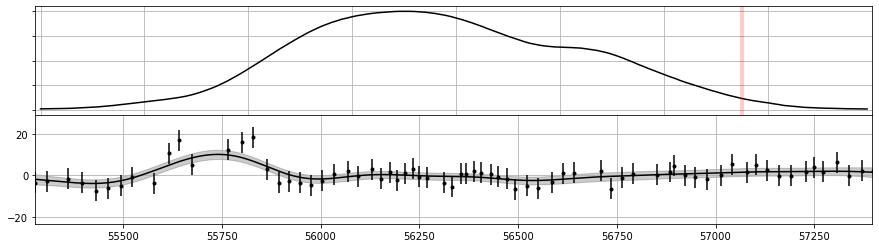

PHASE BIN: 136


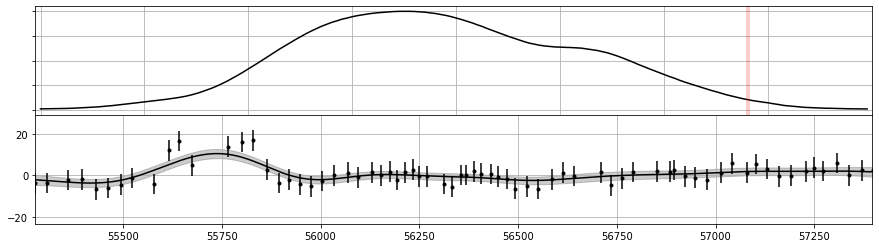

PHASE BIN: 137


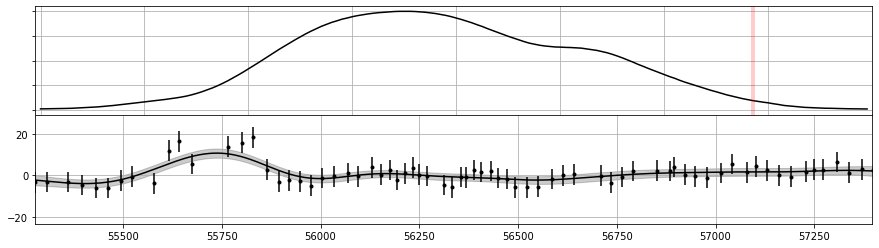

PHASE BIN: 138


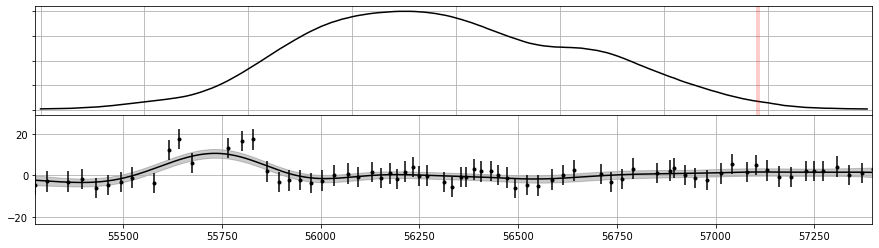

PHASE BIN: 139


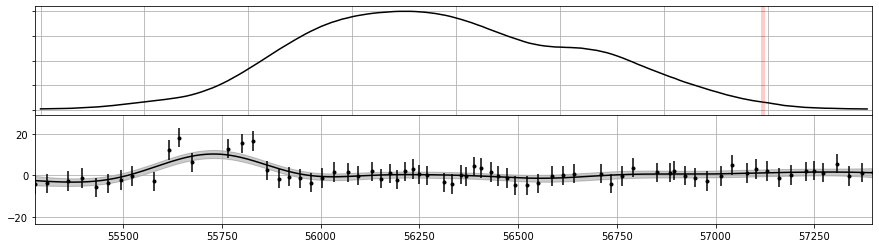

PHASE BIN: 140


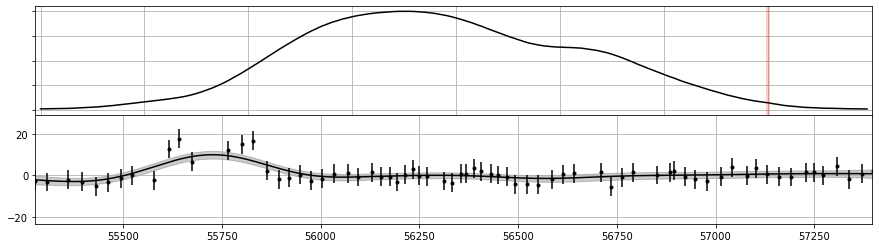

PHASE BIN: 141


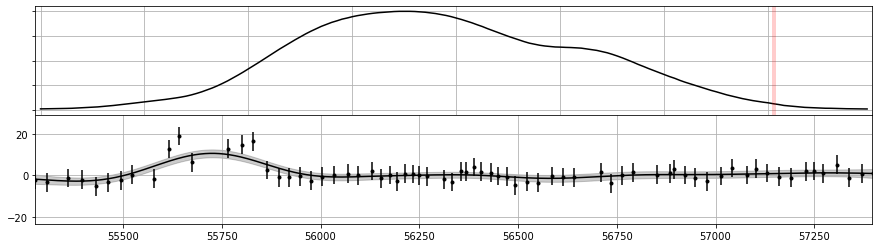

PHASE BIN: 142


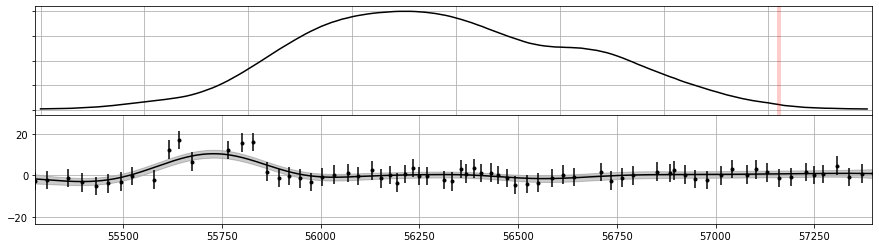

PHASE BIN: 143


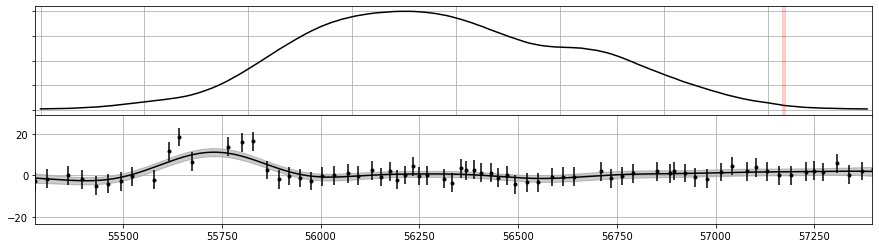

PHASE BIN: 144


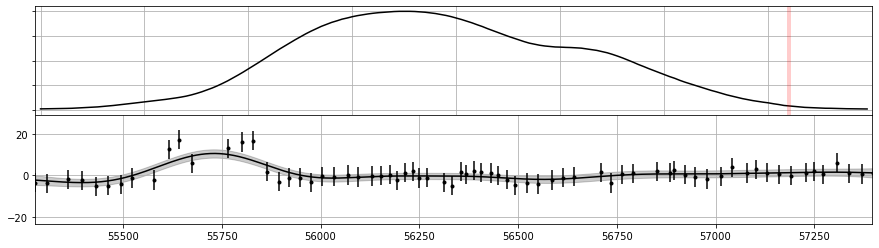

PHASE BIN: 145


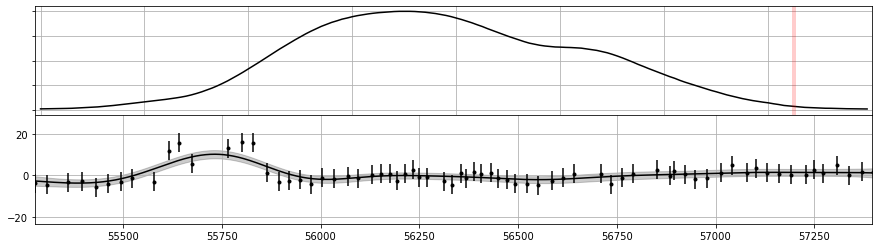

PHASE BIN: 146


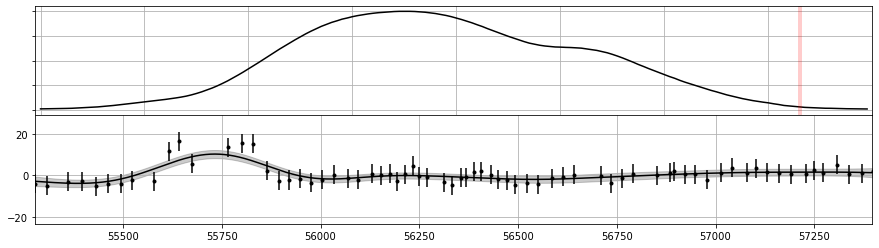

PHASE BIN: 147


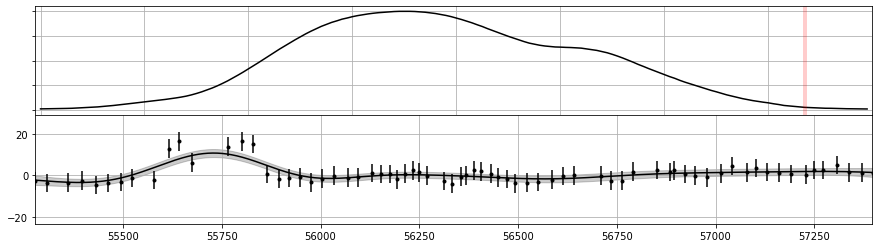

PHASE BIN: 148


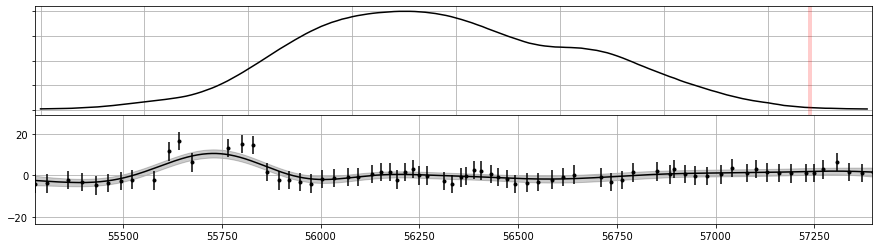

PHASE BIN: 149


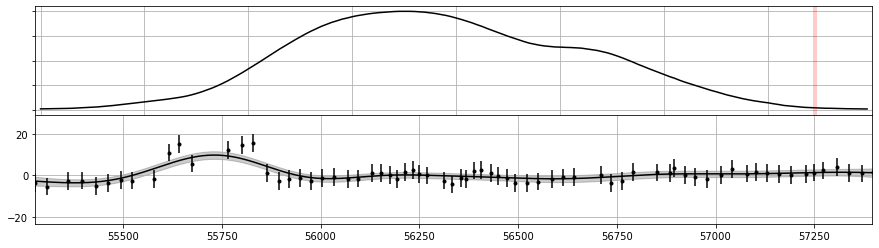

PHASE BIN: 150


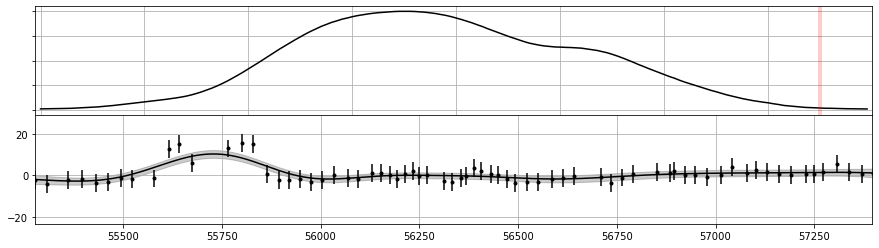

PHASE BIN: 151


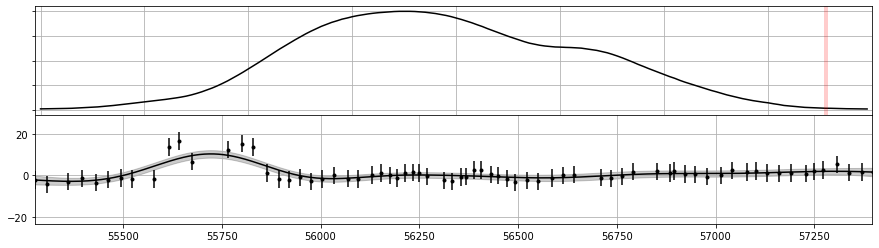

PHASE BIN: 152


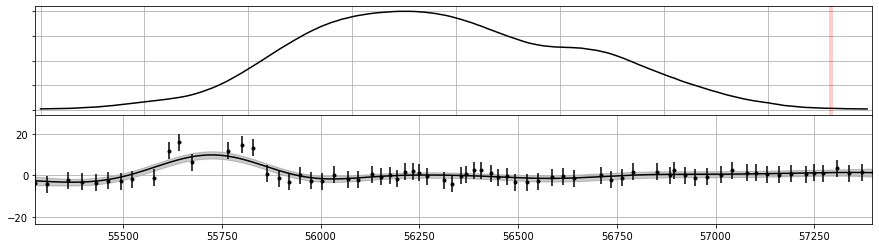

PHASE BIN: 153


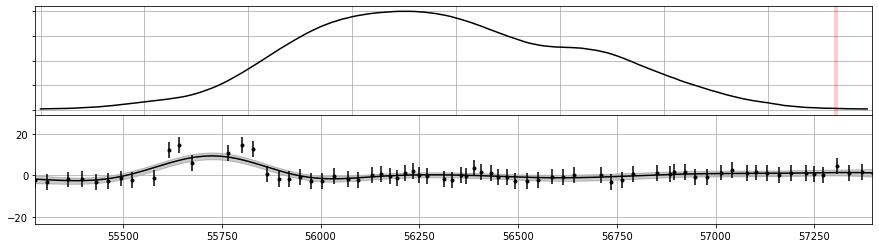

PHASE BIN: 154


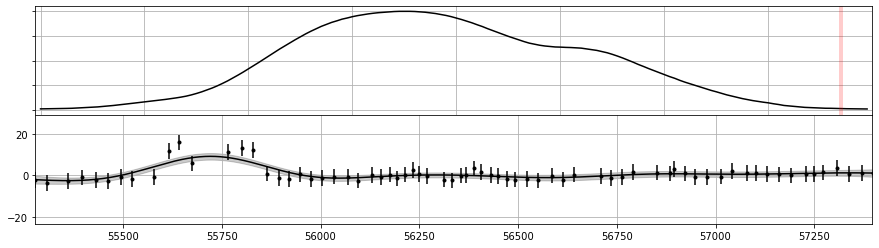

PHASE BIN: 155


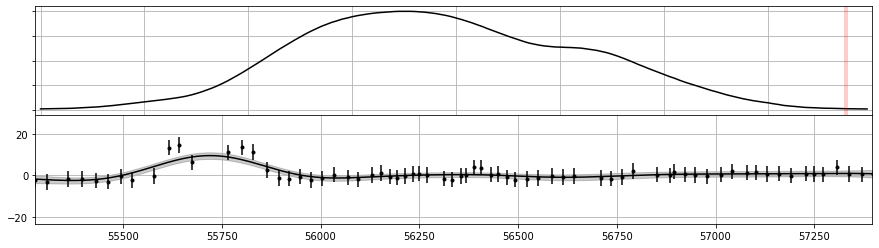

PHASE BIN: 156


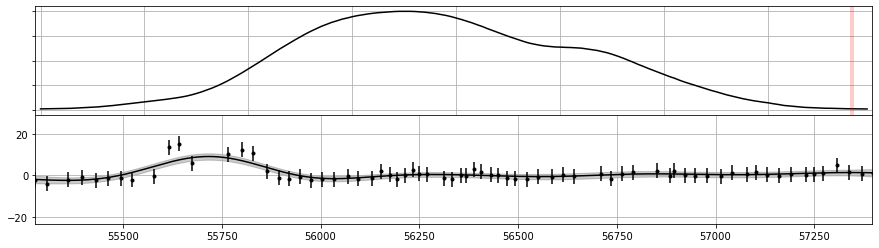

PHASE BIN: 157


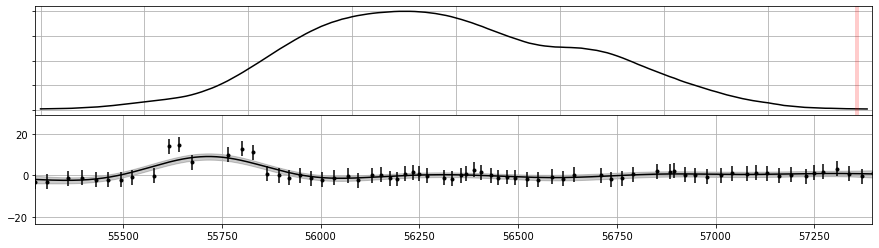

PHASE BIN: 158


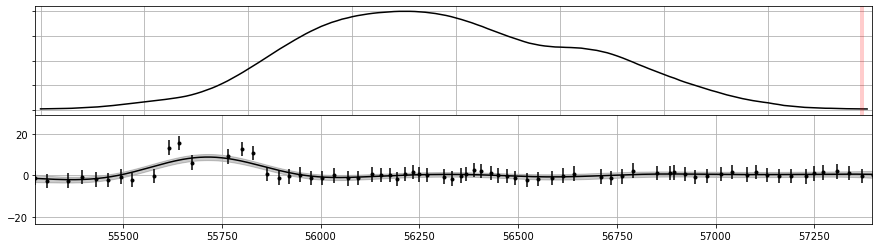

PHASE BIN: 159


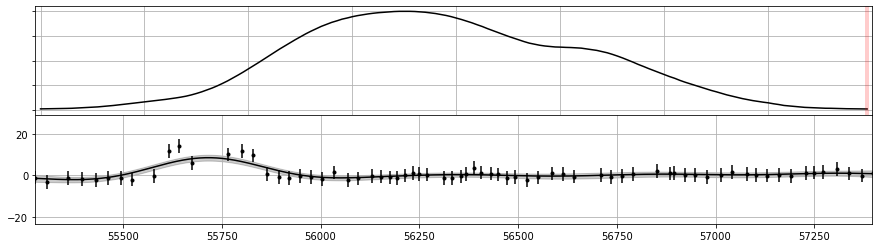

In [26]:
for i in tqdm_notebook(range(gp_data.shape[0])):
    print('PHASE BIN:',i)
    fig = plt.figure(figsize=(15,4))
    gs = gridspec.GridSpec(2,1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(post_bin_match_median[window_begin:window_end],'k')
    plt.vlines(i,-np.max(post_bin_match_median[window_begin:window_end])*0.05,np.max(post_bin_match_median[window_begin:window_end])*1.05,'r',linewidth=4,alpha=0.2)
    ax1.set_xlim(0-1,post_bin_match_median[window_begin:window_end].shape[0])
    ax1.set_ylim(-np.max(post_bin_match_median[window_begin:window_end])*0.05,np.max(post_bin_match_median[window_begin:window_end])*1.05)
    plt.tick_params(axis='y', which='both', left=True, labelleft=False)
    ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    plt.grid()
    
    ax2 = fig.add_subplot(gs[1, 0])
    fig.subplots_adjust(hspace=0.0)
    ax2.plot(gp_mjds[:],gp_data[i,:],'k')
    ax2.errorbar(mjd_remain, all_profile_residuals[i,:], yerr=all_noise[i,:], fmt=".k", capsize=0);
    ax2.fill_between(gp_mjds[:], gp_data[i,:] - np.sqrt(gp_var[i,:]), gp_data[i,:] + np.sqrt(gp_var[i,:]),color="k", alpha=0.2)
    ax2.set_xlim(gp_mjds[0],gp_mjds[-1])
    plot_y_min = np.minimum(np.min(gp_data[:,:] - np.sqrt(gp_var[:,:])),np.min(all_profile_residuals[:,:]-all_noise[:,:]))
    plot_y_max = np.maximum(np.max(gp_data[:,:] + np.sqrt(gp_var[:,:])), np.max(all_profile_residuals[:,:]+all_noise[:,:]))
    ax2.set_ylim(plot_y_min,plot_y_max)
    ax1.tick_params(axis='x', size=20)
    plt.grid()
    plt.show()
    plt.close(fig)

### CALCULATE PEAK FLUX DENSITY (NON-NORMALISED) ACROSS THE DATA SET:

In [27]:
peak_flux_den = np.zeros((aligned_data.shape[1]))

for ad in range(aligned_data.shape[1]):
    peak_flux_den[ad] = np.max(aligned_data[:,ad])

peak_flux_den = peak_flux_den

### PLOT PULSAR VARIABILITY MAP:

/home/paul/academia_local/pulvar/pulvar_functions.py:363: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(date_label_str)


- Date of observations are shown on the variability map as verticle lines.

- The units of the variability map is:
  The standard deviation of all off-pulse phase bins across all observations kept in the analysis.


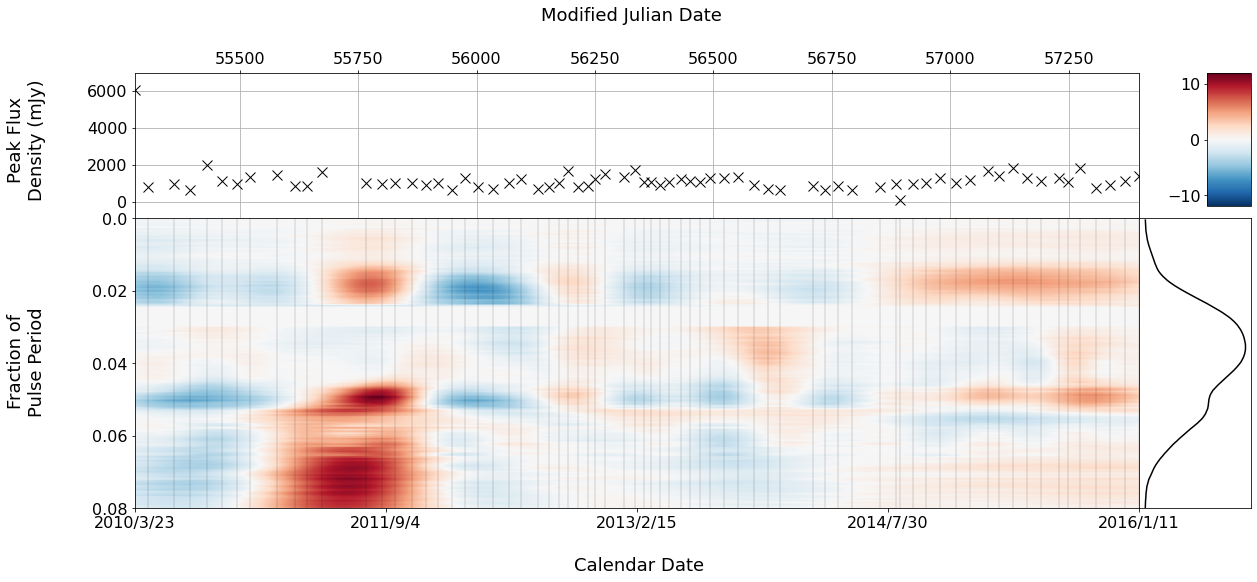

In [28]:
pvf.variability_map_plot(mjd_remain,gp_data,peak_flux_den,post_bin_match_median,window_begin, window_end,data.shape[0]) 
print('- Date of observations are shown on the variability map as verticle lines.\n')
print('- The units of the variability map is:\n  The standard deviation of all off-pulse phase bins across all observations kept in the analysis.')